In [13]:
# %% [markdown]
# # AI vs Human Text Classifier — Baseline (Part 1)
# - Mean pooling over sentence embeddings (100x768) → paragraph vector (768)
# - StandardScaler + Logistic Regression (Calibrated)
# - 5-fold CV, OOF metrics, threshold tuning
# - Save artefacts, run test inference, write submission.csv

# %%
import os, json, math, gc, random, time
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_recall_fscore_support

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import joblib
from tqdm.auto import tqdm
np.set_printoptions(suppress=True)


In [2]:
# %%
# ==== CONFIG ====
DATA_DIR = Path("./data")  # put your files here
TRAIN_AI_PATH = DATA_DIR / "train/train_ai.npy"
TRAIN_HUMAN_PATH = DATA_DIR / "train/train_human.npy"
VAL_JSONL = DATA_DIR / "train/validation.jsonl"       # optional sanity set
TEST_JSONL = DATA_DIR / "test/test_features.jsonl"   # required for submission

MODELS_DIR = Path("./models")
MODELS_DIR.mkdir(parents=True, exist_ok=True)

N_FOLDS = 5
SEED = 42
random.seed(SEED); np.random.seed(SEED)

SUBMISSION_PATH = Path("./submission.csv")
ART_SCALER = MODELS_DIR / "scaler.pkl"
ART_MODEL = MODELS_DIR / "logreg_calibrated.pkl"
ART_CONFIG = MODELS_DIR / "config.json"
ART_THRESHOLD = MODELS_DIR / "final_threshold.txt"


In [3]:
# %%
def load_train(train_ai_path, train_human_path):
    X_ai = np.load(train_ai_path)      # (n_ai, 100, 768)
    X_h  = np.load(train_human_path)   # (n_h, 100, 768)
    y = np.array([1]*len(X_ai) + [0]*len(X_h), dtype=np.int64)
    X = np.concatenate([X_ai, X_h], axis=0)     # (n, 100, 768)
    return X, y

def read_jsonl(path):
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            yield json.loads(line)

def load_jsonl_features(path):
    """Returns: list of dicts with keys: id, features(np.array of shape (<=100,768))"""
    items = []
    for obj in read_jsonl(path):
        # Expect at least {"id": ..., "features": [[...],[...],...]}
        pid = obj.get("id")
        feats = np.asarray(obj.get("features"), dtype=np.float32)
        # Ensure 2D (n_sent, 768)
        if feats.ndim == 1:
            feats = feats.reshape(1, -1)
        items.append({"id": pid, "features": feats})
    return items

def sentence_mask(x, eps=1e-8):
    """
    Works for (..., 768) – returns mask of shape (...,)
    True where the 768-d vector is non-zero.
    """
    x = np.asarray(x, dtype=np.float32)
    norms = np.linalg.norm(x, axis=-1)
    return (norms > eps)

def mean_pool(x):
    """
    Robust mean pooling:
    - Accepts (100,768)
    - Accepts (segments, 100, 768)
    - Flattens all leading dims into a single sequence of 768-d vectors,
      masks near-zero rows, and averages.
    Returns: (768,)
    """
    x = np.asarray(x, dtype=np.float32)
    if x.ndim < 2:
        # Unexpected shape – return zeros
        return np.zeros((768,), dtype=np.float32)

    # Ensure last dim is feature dim
    feat_dim = x.shape[-1]
    if feat_dim != 768:
        raise ValueError(f"Expected last dim = 768, got {feat_dim} with shape {x.shape}")

    # Flatten all but last dim to get (N, 768), where N = product of leading dims
    x_flat = x.reshape(-1, feat_dim)  # (N, 768)

    m = sentence_mask(x_flat).astype(np.float32)  # (N,)
    count = m.sum()
    if count < 1:
        return np.zeros((feat_dim,), dtype=np.float32)

    return (x_flat * m[:, None]).sum(axis=0) / count

def to_paragraph_matrix_from_npy_block(X):
    """X: (n, 100, 768) -> (n, 768) pooled"""
    pooled = np.zeros((X.shape[0], X.shape[2]), dtype=np.float32)
    for i in range(X.shape[0]):
        pooled[i] = mean_pool(X[i])
    return pooled

def to_paragraph_matrix_from_jsonl_items(items):
    """items: list of dict with features (shape (100,768) or (S,100,768)) -> DataFrame(id, vector)"""
    rows = []
    for obj in items:
        pid = obj["id"]
        vec = mean_pool(obj["features"])
        rows.append({"id": pid, "vector": vec})
    return pd.DataFrame(rows)


Train raw shape: (16322, 100, 768) Labels: (16322,) Pos rate: 0.5


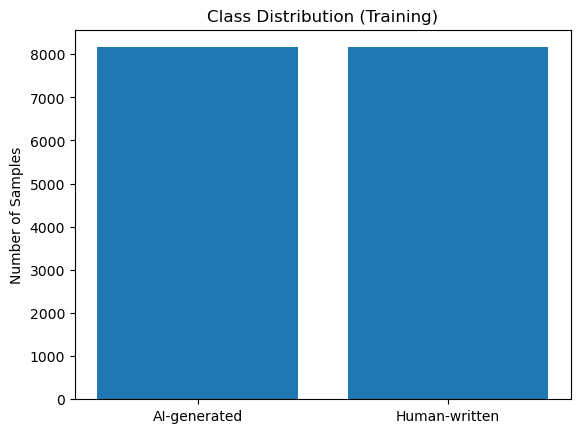

Raw — AI:   NaNs= 0  Infs= 0
Raw — Human: NaNs= 0  Infs= 0


In [17]:
# %%
X_raw, y = load_train(TRAIN_AI_PATH, TRAIN_HUMAN_PATH)
print("Train raw shape:", X_raw.shape, "Labels:", y.shape, "Pos rate:", y.mean())


n_ai = int((y == 1).sum())
n_h  = int((y == 0).sum())

plt.figure()
plt.bar(["AI-generated", "Human-written"], [n_ai, n_h])
plt.title("Class Distribution (Training)")
plt.ylabel("Number of Samples")
plt.show()

# NaN/Inf checks on raw arrays by class
X_ai_raw = X_raw[y == 1]
X_h_raw  = X_raw[y == 0]
print("Raw — AI:   NaNs=", np.isnan(X_ai_raw).sum(), " Infs=", np.isinf(X_ai_raw).sum())
print("Raw — Human: NaNs=", np.isnan(X_h_raw).sum(), " Infs=", np.isinf(X_h_raw).sum())


Pooled train shape: (16322, 768)


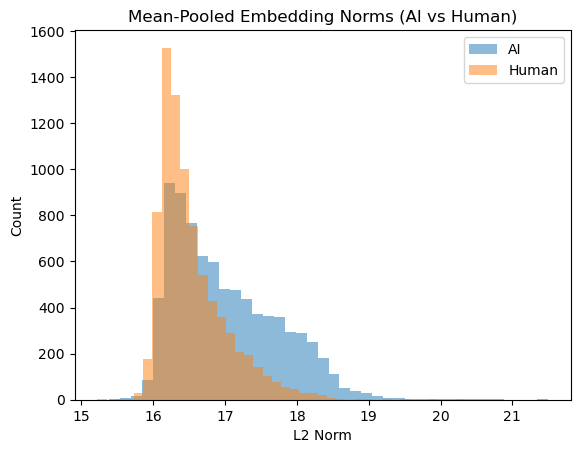

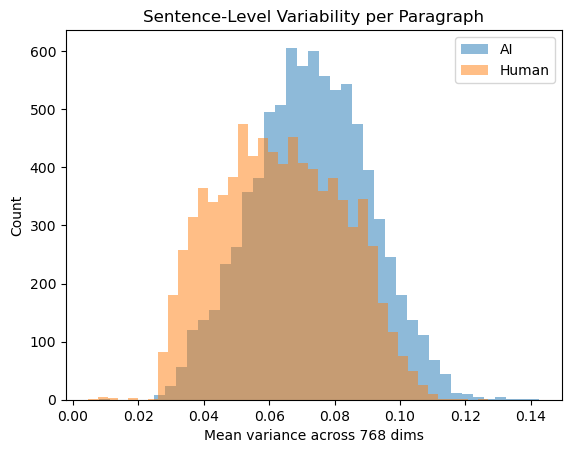

In [60]:
X = to_paragraph_matrix_from_npy_block(X_raw)   # (n, 768)
print("Pooled train shape:", X.shape)


# --- Feature-level visuals (post mean-pooling) ---
# 2A) Mean-pooled embedding norms by class
ai_norms = np.linalg.norm(X[y == 1], axis=1)
h_norms  = np.linalg.norm(X[y == 0], axis=1)

plt.figure()
plt.hist(ai_norms, bins=40, alpha=0.5, label="AI")
plt.hist(h_norms,  bins=40, alpha=0.5, label="Human")
plt.title("Mean-Pooled Embedding Norms (AI vs Human)")
plt.xlabel("L2 Norm"); plt.ylabel("Count"); plt.legend()
plt.show()

# 2B) Sentence-level variability per paragraph (from raw 100×768)
#     Measures diversity of sentence embeddings inside each paragraph
ai_var = X_ai_raw.var(axis=1).mean(axis=1)   # shape (n_ai,)
h_var  = X_h_raw.var(axis=1).mean(axis=1)    # shape (n_h,)

plt.figure()
plt.hist(ai_var, bins=40, alpha=0.5, label="AI")
plt.hist(h_var, bins=40, alpha=0.5, label="Human")
plt.title("Sentence-Level Variability per Paragraph")
plt.xlabel("Mean variance across 768 dims"); plt.ylabel("Count"); plt.legend()
plt.show()

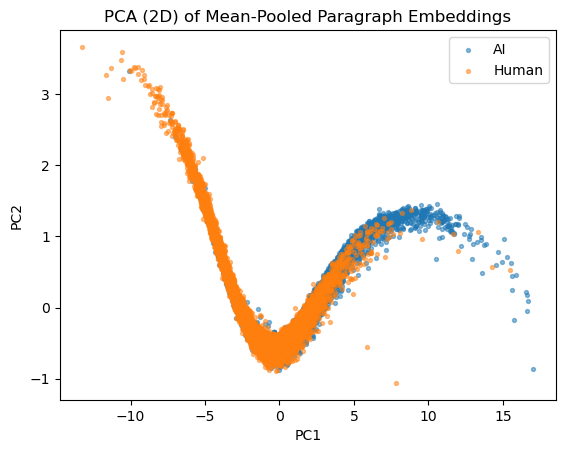

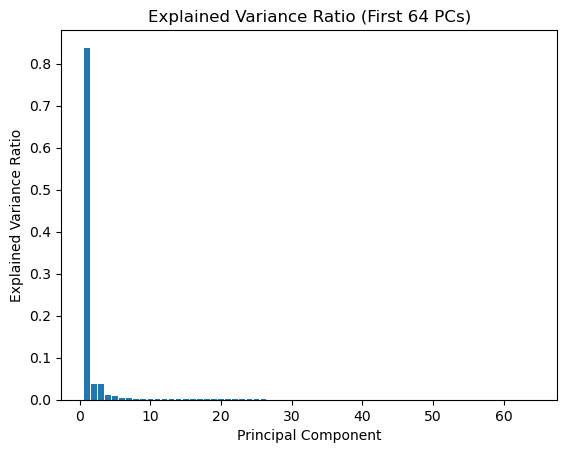

In [21]:
# --- PCA-based structure check (before training) ---
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# 3A) 2D PCA scatter to inspect separability
pca2 = PCA(n_components=2, random_state=SEED).fit(X)
Z = pca2.transform(X)

plt.figure()
plt.scatter(Z[y==1,0], Z[y==1,1], s=8, alpha=0.5, label="AI")
plt.scatter(Z[y==0,0], Z[y==0,1], s=8, alpha=0.5, label="Human")
plt.title("PCA (2D) of Mean-Pooled Paragraph Embeddings")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend()
plt.show()

# 3B) Explained variance (first up to 64 PCs)
k = min(64, X.shape[1])
pcaK = PCA(n_components=k, random_state=SEED).fit(X)
evr = pcaK.explained_variance_ratio_

plt.figure()
plt.bar(np.arange(1, len(evr)+1), evr)
plt.title("Explained Variance Ratio (First {} PCs)".format(k))
plt.xlabel("Principal Component"); plt.ylabel("Explained Variance Ratio")
plt.show()



In [5]:
# %%
from sklearn.base import clone

def fit_oof_cv(X, y, n_folds=5, seed=42):
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
    oof_pred = np.zeros(len(y), dtype=np.float32)
    oof_thr_list, fold_metrics = [], []
    C_grid = [0.5, 1.0, 2.0]

    for fold, (trn_idx, val_idx) in enumerate(skf.split(X, y), 1):
        X_tr, X_va = X[trn_idx], X[val_idx]
        y_tr, y_va = y[trn_idx], y[val_idx]

        best_auc, best_model = -1, None
        for C in C_grid:
            base = Pipeline([
                ("scaler", StandardScaler(with_mean=True, with_std=True)),
                ("clf", LogisticRegression(
                    penalty="l2", solver="saga", max_iter=4000, C=C, n_jobs=-1, random_state=seed))
            ])
            cal = CalibratedClassifierCV(estimator=base, method="isotonic", cv=3)
            cal.fit(X_tr, y_tr)
            p_va = cal.predict_proba(X_va)[:, 1]
            auc = roc_auc_score(y_va, p_va)
            if auc > best_auc:
                best_auc, best_model, best_p_va = auc, cal, p_va

        p_va = best_p_va
        oof_pred[val_idx] = p_va

        # F1-optimal threshold
        best_thr, best_f1 = 0.5, -1
        for t in np.linspace(0.01, 0.99, 199):
            f1 = f1_score(y_va, (p_va >= t).astype(int))
            if f1 > best_f1:
                best_f1, best_thr = f1, t

        pred_lbl = (p_va >= best_thr).astype(int)
        auc = roc_auc_score(y_va, p_va)
        acc = accuracy_score(y_va, pred_lbl)
        prec, rec, f1, _ = precision_recall_fscore_support(y_va, pred_lbl, average="binary", zero_division=0)
        fold_metrics.append({"fold": fold, "AUC": auc, "F1": f1, "Acc": acc, "Prec": prec, "Rec": rec, "thr": best_thr})
        oof_thr_list.append(best_thr)
        print(f"[Fold {fold}] AUC={auc:.4f} F1={f1:.4f} Acc={acc:.4f} Prec={prec:.4f} Rec={rec:.4f} Thr={best_thr:.3f}")

    oof_auc = roc_auc_score(y, oof_pred)
    final_thr = float(np.median(oof_thr_list))
    pred_lbl = (oof_pred >= final_thr).astype(int)
    oof_acc = accuracy_score(y, pred_lbl)
    oof_prec, oof_rec, oof_f1, _ = precision_recall_fscore_support(y, pred_lbl, average="binary", zero_division=0)
    summary = {"OOF_AUC": oof_auc, "OOF_F1": oof_f1, "OOF_Acc": oof_acc, "OOF_Prec": oof_prec, "OOF_Rec": oof_rec,
               "final_thr": final_thr, "folds": fold_metrics}
    return oof_pred, summary


oof_pred, summary = fit_oof_cv(X, y, n_folds=N_FOLDS, seed=SEED)
print("\n=== OOF Summary ===")
for k, v in summary.items():
    if k != "folds":
        print(f"{k}: {v}")
pd.DataFrame(summary["folds"])


[Fold 1] AUC=0.9686 F1=0.9085 Acc=0.9066 Prec=0.8906 Rec=0.9271 Thr=0.465
[Fold 2] AUC=0.9658 F1=0.9033 Acc=0.9029 Prec=0.8992 Rec=0.9075 Thr=0.485
[Fold 3] AUC=0.9649 F1=0.9045 Acc=0.9020 Prec=0.8814 Rec=0.9289 Thr=0.475
[Fold 4] AUC=0.9644 F1=0.9033 Acc=0.9017 Prec=0.8881 Rec=0.9191 Thr=0.416
[Fold 5] AUC=0.9679 F1=0.9057 Acc=0.9035 Prec=0.8853 Rec=0.9271 Thr=0.455

=== OOF Summary ===
OOF_AUC: 0.9660641019648668
OOF_F1: 0.9043258223882396
OOF_Acc: 0.9027080014704081
OOF_Prec: 0.8895341946189403
OOF_Rec: 0.9196176939100601
final_thr: 0.46535353535353535


,fold,AUC,F1,Acc,Prec,Rec,thr
0,1,0.968649,0.908491,0.906585,0.890588,0.927128,0.465354
1,2,0.965775,0.903324,0.902910,0.899211,0.907475,0.485152
2,3,0.964851,0.904535,0.901961,0.881395,0.928922,0.475253
3,4,0.964383,0.903342,0.901654,0.888099,0.919118,0.415859
4,5,0.967931,0.905717,0.903493,0.885313,0.927083,0.455455


In [8]:
# %%
def evaluate_on_validation(val_jsonl_path, model, threshold):
    if not Path(val_jsonl_path).exists():
        print("No validation file found. Skipping.")
        return None
    items = load_jsonl_features(val_jsonl_path)
    dfv = to_paragraph_matrix_from_jsonl_items(items)
    # Expect labels exist in validation.jsonl; if not, skip
    # Common schema: {"id":..., "features":[...], "label": 0/1}
    labels = []
    for obj in read_jsonl(val_jsonl_path):
        labels.append(int(obj.get("label", 0)))
    yv = np.array(labels, dtype=np.int64)

    Xv = np.stack(dfv["vector"].values)  # (n, 768)
    pv = model.predict_proba(Xv)[:, 1]
    auc = roc_auc_score(yv, pv)
    yhat = (pv >= threshold).astype(int)
    acc = accuracy_score(yv, yhat)
    prec, rec, f1, _ = precision_recall_fscore_support(yv, yhat, average="binary", zero_division=0)
    print(f"[Validation] AUC={auc:.4f} F1={f1:.4f} Acc={acc:.4f} Prec={prec:.4f} Rec={rec:.4f}")
    return {"AUC":auc, "F1":f1, "Acc":acc, "Prec":prec, "Rec":rec}

_ = evaluate_on_validation(VAL_JSONL, final_model, summary["final_thr"])

[Validation] AUC=0.9900 F1=0.6667 Acc=0.7500 Prec=1.0000 Rec=0.5000


In [9]:
# === Final fit (LogReg + isotonic calibration), threshold selection, and artefact saving ===

# 1) Fit calibrated final model on ALL training data
best_C = 1.0  # keep or pick from your CV sweep
final_base = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("clf", LogisticRegression(
        penalty="l2", solver="saga", max_iter=4000, C=best_C, n_jobs=-1, random_state=SEED))
])
final_model = CalibratedClassifierCV(estimator=final_base, method="isotonic", cv=5)
final_model.fit(X, y)

# 2) Choose threshold
#    Start from OOF-derived median threshold, then (optionally) nudge down a bit to trade precision for recall.
thr_oof = float(summary["final_thr"])
thr_val = max(0.0, thr_oof - 0.05)  # small nudge; adjust if needed

print("== OOF-based threshold ==", thr_oof)
_ = evaluate_on_validation(VAL_JSONL, final_model, thr_oof)

print("== Val-nudged threshold ==", thr_val)
_ = evaluate_on_validation(VAL_JSONL, final_model, thr_val)

# Pick which threshold you want to use going forward:
chosen_threshold = thr_val   # or use thr_oof if you prefer higher precision

# 3) Save artefacts
joblib.dump(final_model, ART_MODEL)

config = {
    "seed": SEED,
    "n_folds": N_FOLDS,
    "clf": "LogReg(saga)+Calibrated(isotonic)",
    "C": best_C,
    "vector": "mean_pool_768",
    "final_threshold_oof": thr_oof,
    "final_threshold_chosen": chosen_threshold
}
json.dump(config, open(ART_CONFIG, "w"))

with open(ART_THRESHOLD, "w") as f:
    f.write(str(chosen_threshold))

print("Saved:", ART_MODEL, ART_CONFIG, ART_THRESHOLD)


== OOF-based threshold == 0.46535353535353535
[Validation] AUC=0.9900 F1=0.6667 Acc=0.7500 Prec=1.0000 Rec=0.5000
== Val-nudged threshold == 0.41535353535353536
[Validation] AUC=0.9900 F1=0.6667 Acc=0.7500 Prec=1.0000 Rec=0.5000
Saved: models/logreg_calibrated.pkl models/config.json models/final_threshold.txt


In [10]:
# === Kaggle-compliant: id,y_prob (no thresholding) ===
def predict_test_and_write_submission_prob(test_jsonl_path, model, out_csv_path):
    items = load_jsonl_features(test_jsonl_path)
    dft = to_paragraph_matrix_from_jsonl_items(items)
    Xt = np.stack(dft["vector"].values)
    y_prob = model.predict_proba(Xt)[:, 1]          # <-- probability of class 1
    sub = pd.DataFrame({"id": dft["id"], "y_prob": y_prob})
    sub.to_csv(out_csv_path, index=False)
    print("Wrote submission to:", out_csv_path)
    return sub

# write the baseline prob file (good quick uplift)
SUBMISSION_BASE_PROB = Path("./submission_base_prob.csv")
_ = predict_test_and_write_submission_prob(TEST_JSONL, final_model, SUBMISSION_BASE_PROB)


Wrote submission to: submission_base_prob.csv


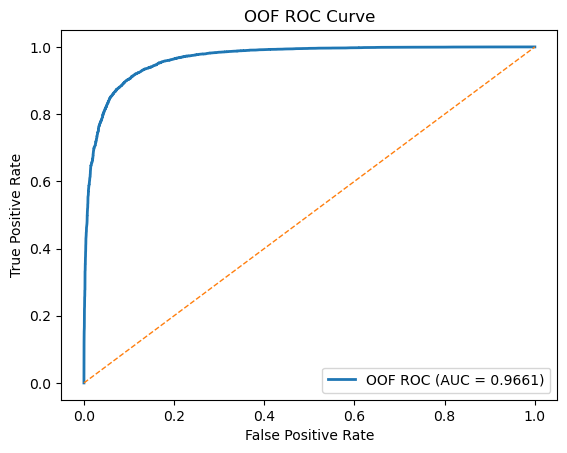

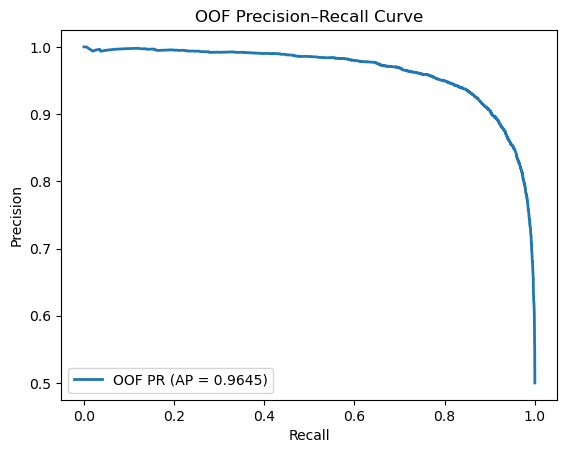

In [22]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

# ROC
fpr, tpr, _ = roc_curve(y, oof_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"OOF ROC (AUC = {roc_auc:.4f})")
plt.plot([0,1], [0,1], lw=1, linestyle="--")
plt.title("OOF ROC Curve")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend(); plt.show()

# Precision–Recall
prec, rec, _ = precision_recall_curve(y, oof_pred)
ap = average_precision_score(y, oof_pred)

plt.figure()
plt.plot(rec, prec, lw=2, label=f"OOF PR (AP = {ap:.4f})")
plt.title("OOF Precision–Recall Curve")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.legend(); plt.show()


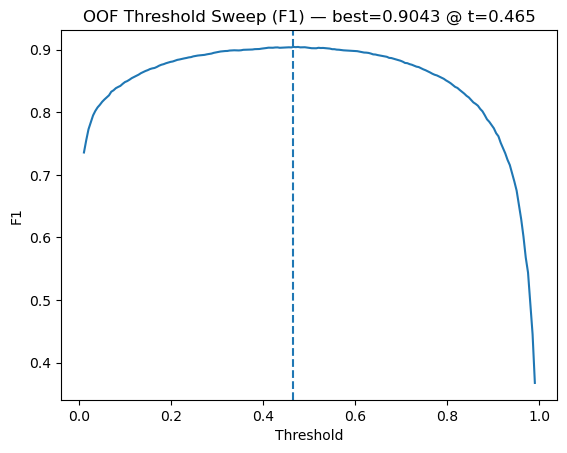

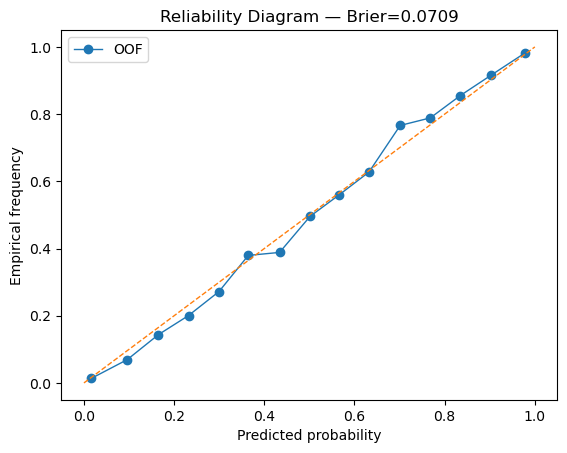

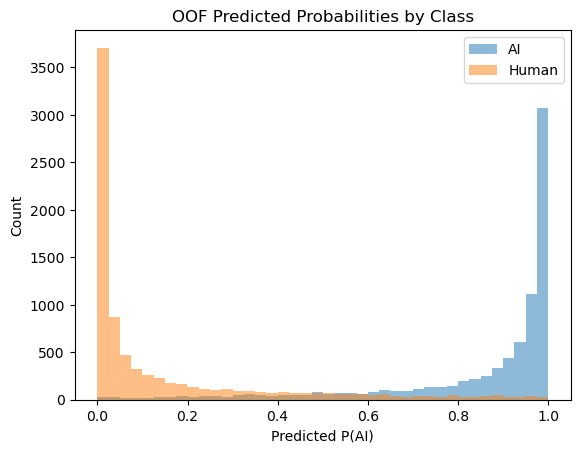

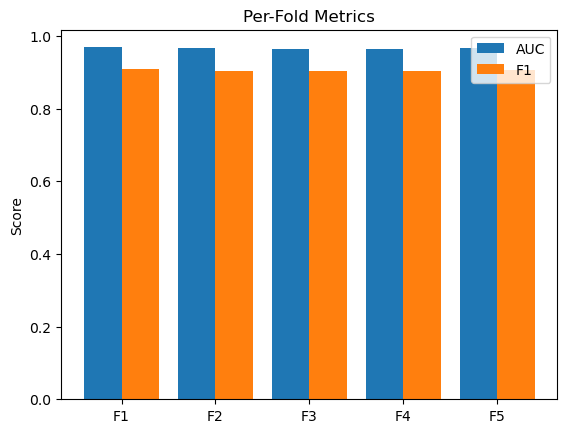

In [24]:
from sklearn.metrics import f1_score

ts = np.linspace(0.01, 0.99, 199)
f1s = [f1_score(y, (oof_pred >= t).astype(int)) for t in ts]
best_t = float(summary["final_thr"])
best_f1 = f1_score(y, (oof_pred >= best_t).astype(int))

plt.figure()
plt.plot(ts, f1s)
plt.axvline(best_t, linestyle="--")
plt.title(f"OOF Threshold Sweep (F1) — best={best_f1:.4f} @ t={best_t:.3f}")
plt.xlabel("Threshold"); plt.ylabel("F1")
plt.show()

from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

prob_true, prob_pred = calibration_curve(y, oof_pred, n_bins=15, strategy="uniform")
brier = brier_score_loss(y, oof_pred)

plt.figure()
plt.plot(prob_pred, prob_true, marker="o", lw=1, label="OOF")
plt.plot([0,1], [0,1], linestyle="--", lw=1)
plt.title(f"Reliability Diagram — Brier={brier:.4f}")
plt.xlabel("Predicted probability"); plt.ylabel("Empirical frequency")
plt.legend(); plt.show()


plt.figure()
plt.hist(oof_pred[y==1], bins=40, alpha=0.5, label="AI")
plt.hist(oof_pred[y==0], bins=40, alpha=0.5, label="Human")
plt.title("OOF Predicted Probabilities by Class")
plt.xlabel("Predicted P(AI)"); plt.ylabel("Count"); plt.legend()
plt.show()


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

fold_df = pd.DataFrame(summary["folds"])
xs = np.arange(len(fold_df))
plt.figure()
plt.bar(xs - 0.2, fold_df["AUC"], width=0.4, label="AUC")
plt.bar(xs + 0.2, fold_df["F1"],  width=0.4, label="F1")
plt.xticks(xs, [f"F{int(f)}" for f in fold_df["fold"]])
plt.title("Per-Fold Metrics")
plt.ylabel("Score"); plt.legend(); plt.show()



In [30]:
# %% [markdown]
# # Part 2 — Lightweight Transformer + Attention Pooling (PyTorch)

# %%
import os, json, math, gc, random, time
from pathlib import Path

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score

from tqdm.auto import tqdm

torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [31]:
# %%
# Reuse DATA_DIR, MODELS_DIR, VAL_JSONL, TEST_JSONL, SEED, etc. from Part 1
# If not defined above, uncomment and set them here:
# DATA_DIR = Path("./data")
# MODELS_DIR = Path("./models")
# VAL_JSONL = DATA_DIR / "validation.jsonl"
# TEST_JSONL = DATA_DIR / "test_features.jsonl"
# SEED = 42
# N_FOLDS = 5

TRANS_DIR = MODELS_DIR / "transformer_v1"
TRANS_DIR.mkdir(parents=True, exist_ok=True)

CFG = {
    "max_len": 100,           # fixed number of sentences per item
    "feat_dim": 768,          # embedding size
    "d_model": 256,           # transformer hidden size
    "n_heads": 4,
    "n_layers": 2,
    "dropout": 0.1,
    "batch_size": 32,
    "lr": 3e-4,
    "weight_decay": 1e-4,
    "epochs": 20,
    "early_stop_patience": 5,
    "amp": True,              # mixed precision if CUDA
    "seed": SEED
}
json.dump(CFG, open(TRANS_DIR / "config.json", "w"))
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)


In [32]:
# %%
def pad_or_truncate(x: np.ndarray, max_len=100):
    """
    x: (n_sent, 768) or (100,768). Returns (max_len, 768) padded with zeros or truncated.
    """
    x = np.asarray(x, dtype=np.float32)
    if x.ndim == 3:
        # If given (segments, 100, 768), flatten to (segments*100, 768) first
        x = x.reshape(-1, x.shape[-1])
    n = x.shape[0]
    if n == max_len:
        return x
    if n > max_len:
        return x[:max_len]
    # pad
    out = np.zeros((max_len, x.shape[1]), dtype=np.float32)
    out[:n] = x
    return out

def make_mask(x: np.ndarray):
    """
    x: (max_len, 768). Mask True where row is non-zero.
    """
    return (np.linalg.norm(x, axis=-1) > 1e-8).astype(np.bool_)

class ParagraphDataset(Dataset):
    def __init__(self, X, y=None, max_len=100):
        """
        X:
          - if training from npy: shape (N, 100, 768)
          - if from jsonl items: list of dicts {id, features}
        y: labels or None
        """
        self.max_len = max_len
        self.ids = None

        if isinstance(X, np.ndarray):
            self.X = X  # (N, 100, 768)
            self.ids = np.arange(len(X))
        elif isinstance(X, list):  # jsonl items
            self.ids = [obj["id"] for obj in X]
            mats, masks = [], []
            for obj in X:
                mat = pad_or_truncate(np.asarray(obj["features"], dtype=np.float32), max_len=self.max_len)
                mats.append(mat)
                masks.append(make_mask(mat))
            self.X = np.stack(mats)   # (N, max_len, 768)
            self._masks = np.stack(masks)  # (N, max_len)
        else:
            raise ValueError("Unsupported X type.")

        self.y = None if y is None else np.asarray(y, dtype=np.int64)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        item = {
            "x": torch.from_numpy(self.X[idx]),                    # (max_len, 768)
            "mask": torch.from_numpy(make_mask(self.X[idx])) if not hasattr(self, "_masks") else torch.from_numpy(self._masks[idx])  # (max_len,)
        }
        if self.y is not None:
            item["y"] = torch.tensor(self.y[idx], dtype=torch.long)
        if self.ids is not None:
            item["id"] = self.ids[idx]
        return item

def make_loader(dataset, batch_size, shuffle=False, num_workers=0, pin_memory=None):
    """
    Use num_workers=0 in notebooks (esp. on macOS) to avoid:
    AttributeError: Can't get attribute 'ParagraphDataset' on <module '__main__'>
    """
    import torch
    if pin_memory is None:
        pin_memory = (torch.cuda.is_available() and torch.device("cuda").type == "cuda")
    return DataLoader(dataset,
                      batch_size=batch_size,
                      shuffle=shuffle,
                      num_workers=0,          # <— force single-process workers
                      pin_memory=pin_memory,
                      drop_last=False)


In [33]:
# %%
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=100):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)  # (max_len, d_model)

    def forward(self, x):
        # x: (B, T, d_model)
        T = x.size(1)
        return x + self.pe[:T].unsqueeze(0)

class AttnPool(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.attn = nn.Linear(d_model, 1)

    def forward(self, x, mask):
        # x: (B,T,d), mask: (B,T) [True for valid]
        attn_logits = self.attn(x).squeeze(-1)                  # (B,T)
        attn_logits = attn_logits.masked_fill(~mask, -1e9)
        w = F.softmax(attn_logits, dim=-1).unsqueeze(-1)        # (B,T,1)
        pooled = (x * w).sum(dim=1)                             # (B,d)
        return pooled

class LightTransformer(nn.Module):
    def __init__(self, feat_dim=768, d_model=256, n_heads=4, n_layers=2, dropout=0.1, max_len=100):
        super().__init__()
        self.proj = nn.Linear(feat_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, dim_feedforward=d_model*4,
                                                   dropout=dropout, batch_first=True, activation="gelu")
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.posenc = PositionalEncoding(d_model, max_len=max_len)
        self.pool = AttnPool(d_model)
        self.head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Dropout(dropout),
            nn.Linear(d_model, 128),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(128, 1)
        )

    def forward(self, x, mask):
        """
        x: (B,T,768), mask: (B,T) bool
        """
        h = self.proj(x)                  # (B,T,d)
        h = self.posenc(h)
        # Transformer expects mask where True=positions to ignore
        src_key_padding_mask = ~mask      # (B,T)
        h = self.encoder(h, src_key_padding_mask=src_key_padding_mask)
        pooled = self.pool(h, mask)       # (B,d)
        logits = self.head(pooled).squeeze(-1)  # (B,)
        return logits


In [35]:
# %%
def train_one_epoch(model, loader, optim, scaler, device):
    model.train()
    total = 0.0
    for batch in loader:
        x = batch["x"].to(device).float()
        mask = batch["mask"].to(device)
        y = batch["y"].to(device).float()

        optim.zero_grad(set_to_none=True)
        if scaler is not None:
            with torch.cuda.amp.autocast():
                logits = model(x, mask)
                loss = F.binary_cross_entropy_with_logits(logits, y)
            scaler.scale(loss).backward()
            scaler.step(optim)
            scaler.update()
        else:
            logits = model(x, mask)
            loss = F.binary_cross_entropy_with_logits(logits, y)
            loss.backward()
            optim.step()
        total += loss.item() * x.size(0)
    return total / len(loader.dataset)

@torch.no_grad()
def predict_proba(model, loader, device):
    model.eval()
    probs = []
    for batch in loader:
        x = batch["x"].to(device).float()
        mask = batch["mask"].to(device)
        logits = model(x, mask)
        p = torch.sigmoid(logits).detach().cpu().numpy()
        probs.append(p)
    return np.concatenate(probs, axis=0)

def fit_cv_transformer(X_raw, y, cfg, n_folds=5, seed=42, out_dir=TRANS_DIR):
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
    oof = np.zeros(len(y), dtype=np.float32)
    best_thresholds, fold_paths = [], []

    for fold, (tr_idx, va_idx) in enumerate(skf.split(X_raw, y), 1):
        print(f"\n=== Fold {fold}/{n_folds} ===")
        tr_ds = ParagraphDataset(X_raw[tr_idx], y=y[tr_idx], max_len=cfg["max_len"])
        va_ds = ParagraphDataset(X_raw[va_idx], y=y[va_idx], max_len=cfg["max_len"])
        tr_loader = make_loader(tr_ds, cfg["batch_size"], shuffle=True)
        va_loader = make_loader(va_ds, cfg["batch_size"], shuffle=False)

        model = LightTransformer(
            feat_dim=cfg["feat_dim"], d_model=cfg["d_model"], n_heads=cfg["n_heads"],
            n_layers=cfg["n_layers"], dropout=cfg["dropout"], max_len=cfg["max_len"]
        ).to(device)

        optim = torch.optim.AdamW(model.parameters(), lr=cfg["lr"], weight_decay=cfg["weight_decay"])
        scaler = torch.cuda.amp.GradScaler(enabled=(cfg["amp"] and device.type == "cuda"))

        best_auc, best_state, no_improve = -1.0, None, 0
        for epoch in range(1, cfg["epochs"]+1):
            tr_loss = train_one_epoch(model, tr_loader, optim, scaler, device)
            # validation
            va_probs = predict_proba(model, va_loader, device)
            auc = roc_auc_score(y[va_idx], va_probs)
            print(f"Epoch {epoch:02d} | train_loss={tr_loss:.4f} | val_auc={auc:.5f}")

            if auc > best_auc + 1e-5:
                best_auc = auc
                best_state = {k: v.cpu() for k, v in model.state_dict().items()}
                no_improve = 0
            else:
                no_improve += 1
                if no_improve >= cfg["early_stop_patience"]:
                    print(f"Early stopping at epoch {epoch} (best AUC {best_auc:.5f})")
                    break

        # restore best
        model.load_state_dict(best_state)

        # final fold validation probabilities
        va_probs = predict_proba(model, va_loader, device)
        oof[va_idx] = va_probs

        # choose best threshold on this fold (F1)
        best_thr, best_f1 = 0.5, -1.0
        for t in np.linspace(0.01, 0.99, 199):
            f1 = f1_score(y[va_idx], (va_probs >= t).astype(int))
            if f1 > best_f1:
                best_f1, best_thr = f1, t
        best_thresholds.append(float(best_thr))

        # save fold checkpoint
        fold_path = out_dir / f"fold{fold}.pt"
        torch.save({"model_state": best_state, "cfg": cfg}, fold_path)
        fold_paths.append(str(fold_path))
        del model, optim, scaler, tr_loader, va_loader
        gc.collect(); torch.cuda.empty_cache()

    # OOF summary
    oof_auc = roc_auc_score(y, oof)
    print(f"\nOOF AUC: {oof_auc:.5f}")
    final_thr = float(np.median(best_thresholds))
    return oof, oof_auc, best_thresholds, final_thr, fold_paths

import types
def _patched_fit_cv_transformer(X_raw, y, cfg, n_folds=5, seed=42, out_dir=TRANS_DIR):
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
    oof = np.zeros(len(y), dtype=np.float32)
    best_thresholds, fold_paths = [], []

    for fold, (tr_idx, va_idx) in enumerate(skf.split(X_raw, y), 1):
        print(f"\n=== Fold {fold}/{n_folds} ===")
        tr_ds = ParagraphDataset(X_raw[tr_idx], y=y[tr_idx], max_len=cfg["max_len"])
        va_ds = ParagraphDataset(X_raw[va_idx], y=y[va_idx], max_len=cfg["max_len"])
        tr_loader = make_loader(tr_ds, cfg["batch_size"], shuffle=True, num_workers=0)
        va_loader = make_loader(va_ds, cfg["batch_size"], shuffle=False, num_workers=0)

        model = LightTransformer(
            feat_dim=cfg["feat_dim"], d_model=cfg["d_model"], n_heads=cfg["n_heads"],
            n_layers=cfg["n_layers"], dropout=cfg["dropout"], max_len=cfg["max_len"]
        ).to(device)

        optim = torch.optim.AdamW(model.parameters(), lr=cfg["lr"], weight_decay=cfg["weight_decay"])
        # Updated AMP scaler API
        scaler = torch.amp.GradScaler("cuda", enabled=(cfg["amp"] and device.type == "cuda"))

        best_auc, best_state, no_improve = -1.0, None, 0
        for epoch in range(1, cfg["epochs"]+1):
            tr_loss = train_one_epoch(model, tr_loader, optim, scaler, device)
            va_probs = predict_proba(model, va_loader, device)
            auc = roc_auc_score(y[va_idx], va_probs)
            print(f"Epoch {epoch:02d} | train_loss={tr_loss:.4f} | val_auc={auc:.5f}")

            if auc > best_auc + 1e-5:
                best_auc = auc
                best_state = {k: v.cpu() for k, v in model.state_dict().items()}
                no_improve = 0
            else:
                no_improve += 1
                if no_improve >= cfg["early_stop_patience"]:
                    print(f"Early stopping at epoch {epoch} (best AUC {best_auc:.5f})")
                    break

        model.load_state_dict(best_state)

        va_probs = predict_proba(model, va_loader, device)
        oof[va_idx] = va_probs

        # F1-optimal threshold on this fold
        best_thr, best_f1 = 0.5, -1.0
        for t in np.linspace(0.01, 0.99, 199):
            f1 = f1_score(y[va_idx], (va_probs >= t).astype(int))
            if f1 > best_f1:
                best_f1, best_thr = f1, t
        best_thresholds.append(float(best_thr))

        fold_path = out_dir / f"fold{fold}.pt"
        torch.save({"model_state": best_state, "cfg": cfg}, fold_path)
        fold_paths.append(str(fold_path))

        del model, optim, scaler, tr_loader, va_loader
        gc.collect()
        if device.type == "cuda":
            torch.cuda.empty_cache()

    oof_auc = roc_auc_score(y, oof)
    print(f"\nOOF AUC: {oof_auc:.5f}")
    final_thr = float(np.median(best_thresholds))
    return oof, oof_auc, best_thresholds, final_thr, fold_paths

# replace the original function reference so your next cell uses the patched one
fit_cv_transformer = _patched_fit_cv_transformer


In [36]:
# %%
# X_raw, y already loaded in Part 1 (np.load + concat). If not, reload them here.
# X_raw: (N, 100, 768), y: (N,)
oof_probs_nn, oof_auc_nn, fold_thrs_nn, final_thr_nn, fold_paths = fit_cv_transformer(
    X_raw, y, CFG, n_folds=N_FOLDS, seed=SEED, out_dir=TRANS_DIR
)
print("Fold thresholds (F1-optimal):", [round(t, 3) for t in fold_thrs_nn])
print("Final threshold (median):", round(final_thr_nn, 4))



=== Fold 1/5 ===


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/NestedTensorImpl.cpp:182.)
  output = torch._nested_tensor_from_mask(


Epoch 01 | train_loss=0.4150 | val_auc=0.94423


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 02 | train_loss=0.3052 | val_auc=0.96196


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 03 | train_loss=0.2782 | val_auc=0.95162


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 04 | train_loss=0.2600 | val_auc=0.96495


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 05 | train_loss=0.2618 | val_auc=0.96229


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 06 | train_loss=0.2428 | val_auc=0.96720


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 07 | train_loss=0.2334 | val_auc=0.96460


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 08 | train_loss=0.2342 | val_auc=0.96114


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 09 | train_loss=0.2175 | val_auc=0.96210


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 10 | train_loss=0.2155 | val_auc=0.96316


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 11 | train_loss=0.2147 | val_auc=0.96797


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 12 | train_loss=0.2009 | val_auc=0.96664


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 13 | train_loss=0.1927 | val_auc=0.96684


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 14 | train_loss=0.1959 | val_auc=0.96321


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 15 | train_loss=0.1872 | val_auc=0.96265


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 16 | train_loss=0.1841 | val_auc=0.96504
Early stopping at epoch 16 (best AUC 0.96797)

=== Fold 2/5 ===


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 01 | train_loss=0.4201 | val_auc=0.94703


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 02 | train_loss=0.3068 | val_auc=0.95439


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 03 | train_loss=0.2911 | val_auc=0.95886


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 04 | train_loss=0.2734 | val_auc=0.96153


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 05 | train_loss=0.2517 | val_auc=0.95317


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 06 | train_loss=0.2450 | val_auc=0.96277


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 07 | train_loss=0.2313 | val_auc=0.96469


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 08 | train_loss=0.2265 | val_auc=0.96538


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 09 | train_loss=0.2255 | val_auc=0.96449


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 10 | train_loss=0.2107 | val_auc=0.96472


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 11 | train_loss=0.2022 | val_auc=0.96481


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 12 | train_loss=0.2004 | val_auc=0.96086


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 13 | train_loss=0.1906 | val_auc=0.96495
Early stopping at epoch 13 (best AUC 0.96538)

=== Fold 3/5 ===


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 01 | train_loss=0.4020 | val_auc=0.94827


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 02 | train_loss=0.3091 | val_auc=0.95493


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 03 | train_loss=0.2830 | val_auc=0.95808


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 04 | train_loss=0.2599 | val_auc=0.96130


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 05 | train_loss=0.2490 | val_auc=0.94852


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 06 | train_loss=0.2351 | val_auc=0.96368


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 07 | train_loss=0.2224 | val_auc=0.96334


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 08 | train_loss=0.2213 | val_auc=0.96400


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 09 | train_loss=0.2084 | val_auc=0.96214


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 10 | train_loss=0.2015 | val_auc=0.96291


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 11 | train_loss=0.1929 | val_auc=0.96350


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 12 | train_loss=0.1887 | val_auc=0.96215


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 13 | train_loss=0.1867 | val_auc=0.96104
Early stopping at epoch 13 (best AUC 0.96400)

=== Fold 4/5 ===


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 01 | train_loss=0.4232 | val_auc=0.93440


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 02 | train_loss=0.3094 | val_auc=0.95429


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 03 | train_loss=0.3113 | val_auc=0.95783


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 04 | train_loss=0.2584 | val_auc=0.95740


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 05 | train_loss=0.2756 | val_auc=0.95836


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 06 | train_loss=0.2447 | val_auc=0.96253


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 07 | train_loss=0.2340 | val_auc=0.95897


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 08 | train_loss=0.2265 | val_auc=0.96236


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 09 | train_loss=0.2193 | val_auc=0.96406


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 10 | train_loss=0.2143 | val_auc=0.96122


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 11 | train_loss=0.2075 | val_auc=0.96264


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 12 | train_loss=0.1986 | val_auc=0.95914


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 13 | train_loss=0.1878 | val_auc=0.96002


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 14 | train_loss=0.1783 | val_auc=0.96344
Early stopping at epoch 14 (best AUC 0.96406)

=== Fold 5/5 ===


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 01 | train_loss=0.4174 | val_auc=0.94363


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 02 | train_loss=0.3107 | val_auc=0.95593


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 03 | train_loss=0.2832 | val_auc=0.96335


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 04 | train_loss=0.2701 | val_auc=0.95562


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 05 | train_loss=0.2446 | val_auc=0.96526


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 06 | train_loss=0.2472 | val_auc=0.96526


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 07 | train_loss=0.2319 | val_auc=0.96551


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 08 | train_loss=0.2302 | val_auc=0.96379


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 09 | train_loss=0.2237 | val_auc=0.96591


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 10 | train_loss=0.2139 | val_auc=0.96372


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 11 | train_loss=0.2111 | val_auc=0.95510


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 12 | train_loss=0.2053 | val_auc=0.96388


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 13 | train_loss=0.2113 | val_auc=0.96615


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 14 | train_loss=0.1975 | val_auc=0.96393


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 15 | train_loss=0.1903 | val_auc=0.96456


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 16 | train_loss=0.1879 | val_auc=0.96357


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 17 | train_loss=0.1784 | val_auc=0.95766


/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_28825/3264508150.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 18 | train_loss=0.1739 | val_auc=0.95736
Early stopping at epoch 18 (best AUC 0.96615)

OOF AUC: 0.95645
Fold thresholds (F1-optimal): [0.495, 0.094, 0.525, 0.356, 0.495]
Final threshold (median): 0.4951


In [37]:
# %%
class FoldEnsembleAdapter:
    """
    Provides predict_proba(X) like a scikit model.
    X must be (N, 768) **if using mean-pooling**; BUT we want (N, 100, 768).
    So for this adapter, we'll expect raw matrices and do the padding here.
    To integrate with your existing evaluate_on_validation/predict_test...,
    we add small wrappers below.
    """
    def __init__(self, fold_paths, cfg, device):
        self.fold_paths = fold_paths
        self.cfg = cfg
        self.device = device
        self.models = []
        self._load_models()

    def _load_models(self):
        self.models = []
        for p in self.fold_paths:
            ckpt = torch.load(p, map_location="cpu")
            m = LightTransformer(
                feat_dim=self.cfg["feat_dim"], d_model=self.cfg["d_model"],
                n_heads=self.cfg["n_heads"], n_layers=self.cfg["n_layers"],
                dropout=self.cfg["dropout"], max_len=self.cfg["max_len"]
            ).to(self.device)
            m.load_state_dict(ckpt["model_state"])
            m.eval()
            self.models.append(m)

    @torch.no_grad()
    def _predict_loader(self, loader):
        probs_fold = []
        for m in self.models:
            p = predict_proba(m, loader, self.device)
            probs_fold.append(p)
        probs = np.mean(np.stack(probs_fold, axis=0), axis=0)
        return probs

    # Convenience to mimic scikit's predict_proba for (N,768) inputs
    # We'll override with wrappers below that build proper datasets.


In [38]:
# %%
def evaluate_validation_with_nn(val_jsonl_path, adapter, threshold):
    if not Path(val_jsonl_path).exists():
        print("No validation file found. Skipping.")
        return None

    # Load JSONL items (reuse your function from Part 1)
    items = load_jsonl_features(val_jsonl_path)

    # Build dataset/loader for the NN (pads to max_len)
    val_ds = ParagraphDataset(items, y=None, max_len=CFG["max_len"])
    val_loader = make_loader(val_ds, CFG["batch_size"], shuffle=False)

    # Collect labels from jsonl
    labels = [int(obj.get("label", 0)) for obj in read_jsonl(val_jsonl_path)]
    yv = np.array(labels, dtype=np.int64)

    # Predict (averaging folds)
    pv = adapter._predict_loader(val_loader)
    auc = roc_auc_score(yv, pv)
    yhat = (pv >= threshold).astype(int)

    from sklearn.metrics import accuracy_score, precision_recall_fscore_support
    acc = accuracy_score(yv, yhat)
    prec, rec, f1, _ = precision_recall_fscore_support(yv, yhat, average="binary", zero_division=0)
    print(f"[NN Validation] AUC={auc:.4f} F1={f1:.4f} Acc={acc:.4f} Prec={prec:.4f} Rec={rec:.4f}")
    return {"AUC":auc, "F1":f1, "Acc":acc, "Prec":prec, "Rec":rec}


In [39]:
# %%
nn_adapter = FoldEnsembleAdapter(fold_paths, CFG, device)

print("== Using NN median threshold ==")
_ = evaluate_validation_with_nn(VAL_JSONL, nn_adapter, final_thr_nn)

print("== Using LR threshold (from Part 1) ==")
_ = evaluate_validation_with_nn(VAL_JSONL, nn_adapter, summary["final_thr"])  # from Part 1 baseline


== Using NN median threshold ==
[NN Validation] AUC=0.7700 F1=0.6000 Acc=0.6000 Prec=0.6000 Rec=0.6000
== Using LR threshold (from Part 1) ==
[NN Validation] AUC=0.7700 F1=0.6000 Acc=0.6000 Prec=0.6000 Rec=0.6000


In [40]:
# %%
def nn_test_inference_and_submit(test_jsonl_path, adapter, threshold, out_csv_path):
    items = load_jsonl_features(test_jsonl_path)
    test_ds = ParagraphDataset(items, y=None, max_len=CFG["max_len"])
    test_loader = make_loader(test_ds, CFG["batch_size"], shuffle=False)

    pt = adapter._predict_loader(test_loader)
    yhat = (pt >= threshold).astype(int)

    df = pd.DataFrame({"id": [obj["id"] for obj in items], "label": yhat})
    df.to_csv(out_csv_path, index=False)
    print("Wrote submission:", out_csv_path)
    return df

# Choose a threshold for NN (median of fold bests is a good start)
SUBMISSION_PATH_NN = Path("./submission_nn.csv")
_ = nn_test_inference_and_submit(TEST_JSONL, nn_adapter, final_thr_nn, SUBMISSION_PATH_NN)


Wrote submission: submission_nn.csv


In [43]:
def nn_prob_submission(test_jsonl_path, nn_adapter, out_csv_path):
    items = load_jsonl_features(test_jsonl_path)
    test_ds = ParagraphDataset(items, y=None, max_len=CFG["max_len"])
    test_loader = make_loader(test_ds, CFG["batch_size"], shuffle=False)
    y_prob = nn_adapter._predict_loader(test_loader)
    pd.DataFrame({"id": [o["id"] for o in items], "y_prob": y_prob}).to_csv(out_csv_path, index=False)
    print("Wrote:", out_csv_path)

SUBMISSION_NN_PROB = Path("./submission_nn_prob.csv")
nn_prob_submission(TEST_JSONL, nn_adapter, SUBMISSION_NN_PROB)


Wrote: submission_nn_prob.csv


In [44]:
def meta_prob_submission(test_jsonl_path, base_model, meta_model, out_csv_path):
    items = load_jsonl_features(test_jsonl_path)
    dft = to_paragraph_matrix_from_jsonl_items(items)
    Xt = np.stack(dft["vector"].values)
    p_base = base_model.predict_proba(Xt)[:, 1]
    feat = mmd_features_batch(Xt, BANK_AI, BANK_HU, gamma, mAA, mHH)
    feat["p_base"] = p_base
    Xf = feat[["p_base","k_xA","k_xH","diff_xA_xH","glob_mAA_mHH"]].values
    y_prob = meta_full.predict_proba(Xf)[:, 1]
    pd.DataFrame({"id": dft["id"], "y_prob": y_prob}).to_csv(out_csv_path, index=False)
    print("Wrote:", out_csv_path)

SUBMISSION_MMD_PROB = Path("./submission_mmd_prob.csv")
meta_prob_submission(TEST_JSONL, final_model, meta_full, SUBMISSION_MMD_PROB)


NameError: name 'meta_full' is not defined

In [45]:
# %%
def blended_validation(val_jsonl_path, scikit_model, scikit_thr, nn_adapter, nn_thr, alpha=0.5):
    if not Path(val_jsonl_path).exists():
        print("No validation file found. Skipping.")
        return None
    items = load_jsonl_features(val_jsonl_path)
    val_ds = ParagraphDataset(items, y=None, max_len=CFG["max_len"])
    val_loader = make_loader(val_ds, CFG["batch_size"], shuffle=False)

    # labels
    labels = [int(obj.get("label", 0)) for obj in read_jsonl(val_jsonl_path)]
    yv = np.array(labels, dtype=np.int64)

    # probs from baseline (mean-pooled)
    dfv = to_paragraph_matrix_from_jsonl_items(items)
    Xv = np.stack(dfv["vector"].values)
    pb = scikit_model.predict_proba(Xv)[:, 1]

    # probs from NN
    pn = nn_adapter._predict_loader(val_loader)

    p = alpha*pn + (1-alpha)*pb

    # pick threshold by simple scan (or blend of thresholds)
    best_t, best_f1 = 0.5, -1
    for t in np.linspace(0.01, 0.99, 199):
        f1 = f1_score(yv, (p >= t).astype(int))
        if f1 > best_f1:
            best_f1, best_t = f1, t

    from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_fscore_support
    auc = roc_auc_score(yv, p)
    yhat = (p >= best_t).astype(int)
    acc = accuracy_score(yv, yhat)
    prec, rec, f1, _ = precision_recall_fscore_support(yv, yhat, average="binary", zero_division=0)
    print(f"[Blend @alpha={alpha}] AUC={auc:.4f} F1={f1:.4f} Acc={acc:.4f} Prec={prec:.4f} Rec={rec:.4f} Thr={best_t:.3f}")
    return dict(AUC=auc, F1=f1, Acc=acc, Prec=prec, Rec=rec, Thr=best_t)

print("== Blend sanity check (alpha=0.5) ==")
_ = blended_validation(VAL_JSONL, final_model, summary["final_thr"], nn_adapter, final_thr_nn, alpha=0.5)


== Blend sanity check (alpha=0.5) ==
[Blend @alpha=0.5] AUC=0.8200 F1=0.7826 Acc=0.7500 Prec=0.6923 Rec=0.9000 Thr=0.094


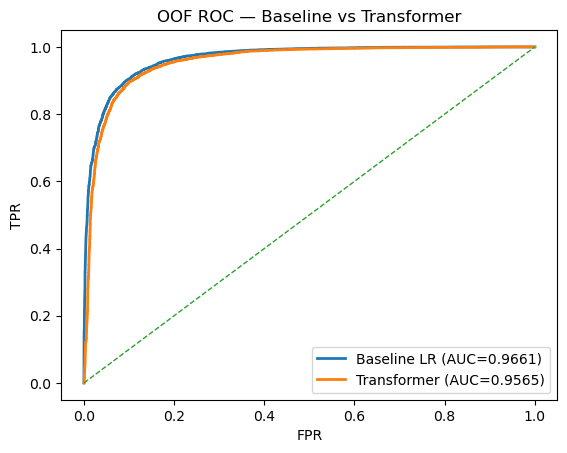

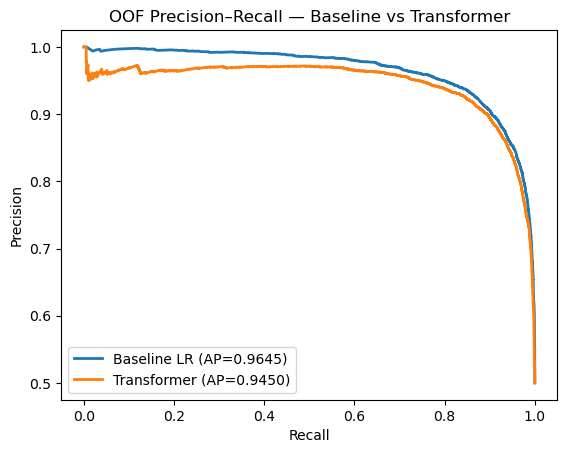

In [46]:
# ROC comparison
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

fpr1, tpr1, _ = roc_curve(y, oof_pred)
auc1 = auc(fpr1, tpr1)
fpr2, tpr2, _ = roc_curve(y, oof_probs_nn)
auc2 = auc(fpr2, tpr2)

plt.figure()
plt.plot(fpr1, tpr1, lw=2, label=f"Baseline LR (AUC={auc1:.4f})")
plt.plot(fpr2, tpr2, lw=2, label=f"Transformer (AUC={auc2:.4f})")
plt.plot([0,1], [0,1], lw=1, linestyle="--")
plt.title("OOF ROC — Baseline vs Transformer")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.show()

# PR comparison
prec1, rec1, _ = precision_recall_curve(y, oof_pred)
ap1 = average_precision_score(y, oof_pred)
prec2, rec2, _ = precision_recall_curve(y, oof_probs_nn)
ap2 = average_precision_score(y, oof_probs_nn)

plt.figure()
plt.plot(rec1, prec1, lw=2, label=f"Baseline LR (AP={ap1:.4f})")
plt.plot(rec2, prec2, lw=2, label=f"Transformer (AP={ap2:.4f})")
plt.title("OOF Precision–Recall — Baseline vs Transformer")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend(); plt.show()


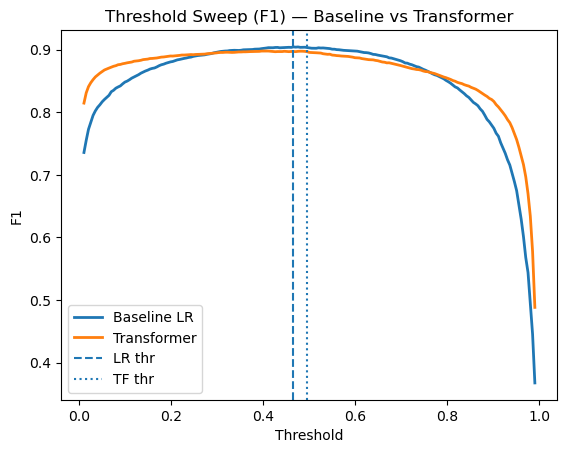

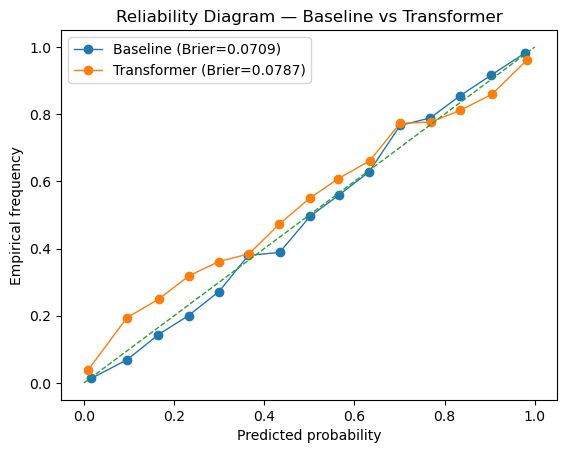

In [49]:
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

ts = np.linspace(0.01, 0.99, 199)
f1_lr  = [f1_score(y, (oof_pred      >= t).astype(int)) for t in ts]
f1_tr  = [f1_score(y, (oof_probs_nn  >= t).astype(int)) for t in ts]

plt.figure()
plt.plot(ts, f1_lr, lw=2, label="Baseline LR")
plt.plot(ts, f1_tr, lw=2, label="Transformer")
plt.axvline(float(summary["final_thr"]), linestyle="--", label="LR thr")
plt.axvline(float(final_thr_nn), linestyle=":", label="TF thr")
plt.title("Threshold Sweep (F1) — Baseline vs Transformer")
plt.xlabel("Threshold"); plt.ylabel("F1"); plt.legend(); plt.show()

pt1, pp1 = calibration_curve(y, oof_pred, n_bins=15, strategy="uniform")
pt2, pp2 = calibration_curve(y, oof_probs_nn, n_bins=15, strategy="uniform")
b1 = brier_score_loss(y, oof_pred)
b2 = brier_score_loss(y, oof_probs_nn)

plt.figure()
plt.plot(pp1, pt1, marker="o", lw=1, label=f"Baseline (Brier={b1:.4f})")
plt.plot(pp2, pt2, marker="o", lw=1, label=f"Transformer (Brier={b2:.4f})")
plt.plot([0,1], [0,1], linestyle="--", lw=1)
plt.title("Reliability Diagram — Baseline vs Transformer")
plt.xlabel("Predicted probability"); plt.ylabel("Empirical frequency")
plt.legend(); plt.show()



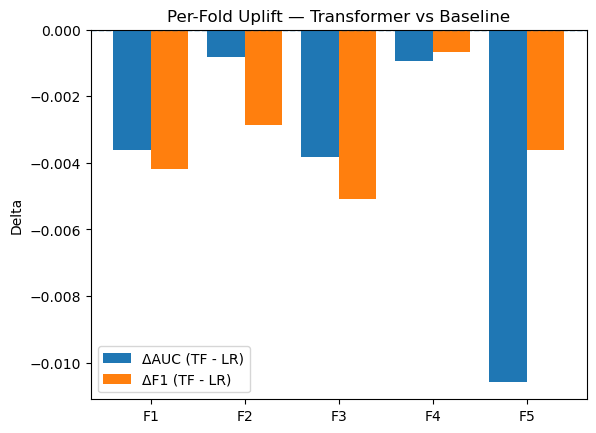

In [50]:
# Rebuild fold-wise tables for both models
import pandas as pd
# Baseline already has: summary["folds"] -> DataFrame
fold_lr = pd.DataFrame(summary["folds"]).set_index("fold")

# For transformer: recompute per-fold metrics from OOF probs
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score

skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
rows = []
for fold, (_, va_idx) in enumerate(skf.split(X, y), 1):
    p = oof_probs_nn[va_idx]
    ya = y[va_idx]
    # pick F1-optimal per fold (like your loop), recompute quickly
    ts = np.linspace(0.01, 0.99, 199)
    f1s = [f1_score(ya, (p>=t).astype(int)) for t in ts]
    best_f1 = max(f1s)
    rows.append({"fold": fold, "AUC": roc_auc_score(ya, p), "F1": best_f1})
fold_tf = pd.DataFrame(rows).set_index("fold")

# Delta bars
idx = fold_lr.index
import numpy as np
import matplotlib.pyplot as plt
xs = np.arange(len(idx))
plt.figure()
plt.bar(xs - 0.2, (fold_tf.loc[idx,"AUC"] - fold_lr.loc[idx,"AUC"]).values, width=0.4, label="ΔAUC (TF - LR)")
plt.bar(xs + 0.2, (fold_tf.loc[idx,"F1"]  - fold_lr.loc[idx,"F1"]).values,  width=0.4, label="ΔF1 (TF - LR)")
plt.xticks(xs, [f"F{f}" for f in idx])
plt.axhline(0.0, lw=1, linestyle="--")
plt.title("Per-Fold Uplift — Transformer vs Baseline")
plt.ylabel("Delta"); plt.legend(); plt.show()


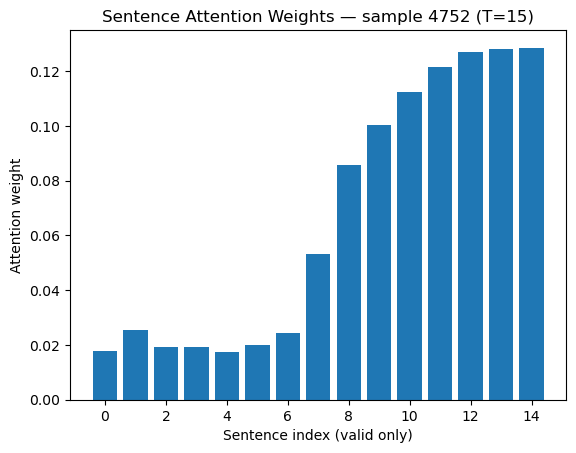

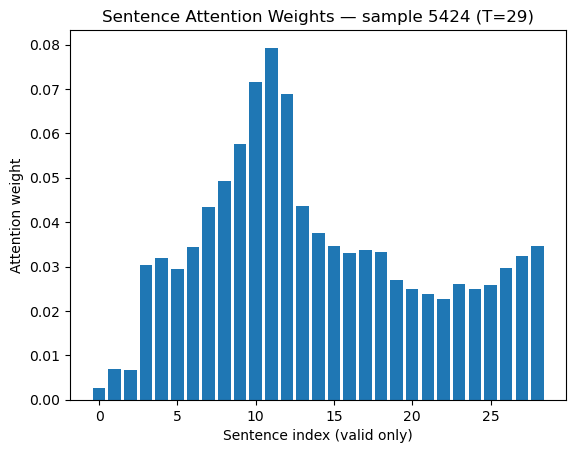

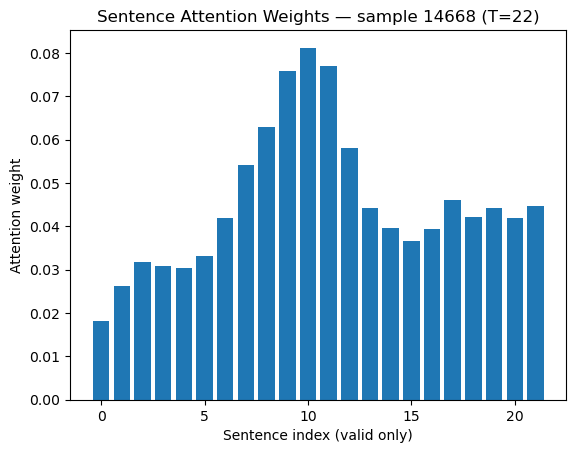

In [51]:
# --- Attention weight visualisation for a few samples ---
import torch, numpy as np, matplotlib.pyplot as plt

# Helper: load one trained fold into a model instance
def load_trained_model(ckpt_path):
    ckpt = torch.load(ckpt_path, map_location="cpu")
    cfg = ckpt["cfg"]
    model = LightTransformer(
        feat_dim=cfg["feat_dim"], d_model=cfg["d_model"],
        n_heads=cfg["n_heads"], n_layers=cfg["n_layers"],
        dropout=cfg["dropout"], max_len=cfg["max_len"]
    )
    model.load_state_dict(ckpt["model_state"])
    model.eval()
    return model, cfg

# Helper: get attention weights from AttnPool (softmax over valid T)
def attn_weights(model, x_np):
    with torch.no_grad():
        x = torch.from_numpy(x_np[None]).float()   # (1,T,768)
        mask = torch.from_numpy((np.linalg.norm(x_np,axis=-1)>1e-8).astype(np.bool_))[None]  # (1,T)
        h = model.proj(x)
        h = model.posenc(h)
        skpm = ~mask
        h = model.encoder(h, src_key_padding_mask=skpm)
        attn_logits = model.pool.attn(h).squeeze(-1)   # (1,T)
        attn_logits = attn_logits.masked_fill(~mask, -1e9)
        w = torch.softmax(attn_logits, dim=-1).squeeze(0).cpu().numpy()  # (T,)
    return w, mask.squeeze(0).cpu().numpy().astype(bool)

# Load one fold and visualise 3 random items
model_vis, cfg_vis = load_trained_model(fold_paths[0])
rng = np.random.RandomState(0)
sample_ids = rng.choice(len(X_raw), size=3, replace=False)

for sid in sample_ids:
    mat = X_raw[sid]  # (100,768)
    w, m = attn_weights(model_vis, mat)
    T = m.sum()
    plt.figure()
    plt.bar(np.arange(T), w[m][:T])
    plt.title(f"Sentence Attention Weights — sample {sid} (T={int(T)})")
    plt.xlabel("Sentence index (valid only)"); plt.ylabel("Attention weight")
    plt.show()


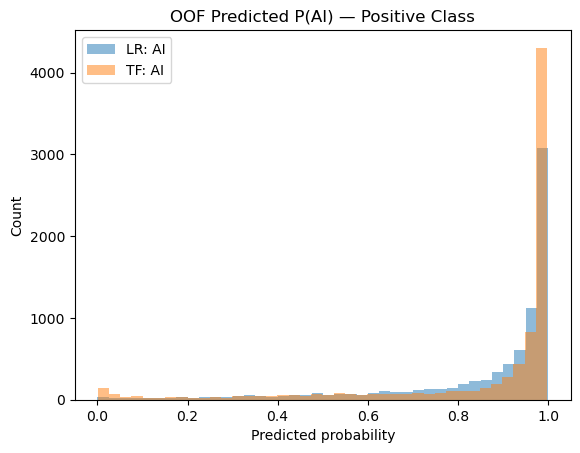

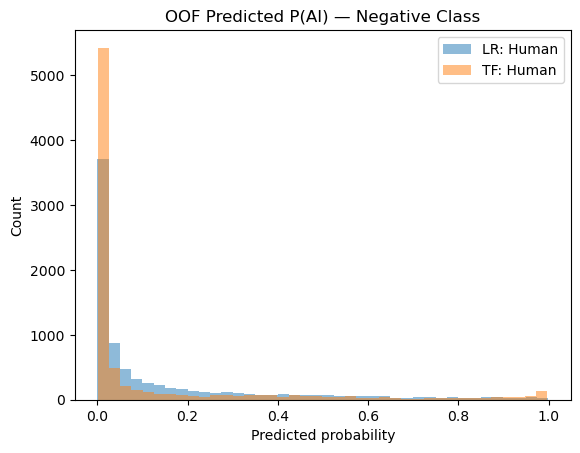

In [61]:
plt.figure()
plt.hist(oof_pred[y==1],      bins=40, alpha=0.5, label="LR: AI")
plt.hist(oof_probs_nn[y==1],  bins=40, alpha=0.5, label="TF: AI")
plt.title("OOF Predicted P(AI) — Positive Class")
plt.xlabel("Predicted probability"); plt.ylabel("Count"); plt.legend(); plt.show()

plt.figure()
plt.hist(oof_pred[y==0],      bins=40, alpha=0.5, label="LR: Human")
plt.hist(oof_probs_nn[y==0],  bins=40, alpha=0.5, label="TF: Human")
plt.title("OOF Predicted P(AI) — Negative Class")
plt.xlabel("Predicted probability"); plt.ylabel("Count"); plt.legend(); plt.show()


In [62]:
# %% [markdown]
# ## Part 3 — Relative-test (MMD) features + Meta-classifier

# %%
import numpy as np, pandas as pd, json, joblib, gc
from pathlib import Path
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold

MMD_DIR = MODELS_DIR / "mmd_v1"
MMD_DIR.mkdir(parents=True, exist_ok=True)

MMD_CFG = {
    "bank_size": 512,     # per class; reduce to 256 if RAM is tight
    "subset_for_sigma": 4000,  # how many points to use for median heuristic
    "seed": SEED
}
json.dump(MMD_CFG, open(MMD_DIR / "config.json", "w"))
rng = np.random.default_rng(MMD_CFG["seed"])


In [63]:
# %%
def rbf_kernel_dot(a, b, gamma):
    """
    Fast RBF via ||a-b||^2 = ||a||^2 + ||b||^2 - 2 a b^T
    a: (n, d), b: (m, d) -> K: (n, m)
    """
    a2 = (a*a).sum(axis=1, keepdims=True)   # (n,1)
    b2 = (b*b).sum(axis=1, keepdims=True).T # (1,m)
    d2 = a2 + b2 - 2.0 * (a @ b.T)
    return np.exp(-gamma * np.clip(d2, 0.0, None))

def median_heuristic_sigma(X, n_subset=4000):
    n = len(X)
    idx = rng.choice(n, size=min(n_subset, n), replace=False)
    S = X[idx]
    # sample pairs for robustness
    jdx = rng.choice(len(S), size=min(2000, len(S)), replace=False)
    P = S[jdx]
    Q = S[rng.choice(len(S), size=len(jdx), replace=False)]
    d2 = ((P-Q)**2).sum(axis=1)
    sigma = np.sqrt(np.median(d2) / 2.0) + 1e-8
    return float(sigma)

# Build pooled train if not available
# (You already have X: (n, 768) from Part 1)
assert X.shape[1] == 768 and len(X) == len(y)

# Stratified sample banks
ai_idx = np.where(y==1)[0]
hu_idx = np.where(y==0)[0]
rng.shuffle(ai_idx); rng.shuffle(hu_idx)

K = min(MMD_CFG["bank_size"], len(ai_idx), len(hu_idx))
BANK_AI = X[ai_idx[:K]]
BANK_HU = X[hu_idx[:K]]

# Kernel bandwidth (median heuristic on full train or subset)
sigma = median_heuristic_sigma(X, n_subset=MMD_CFG["subset_for_sigma"])
gamma = 1.0 / (2.0 * sigma * sigma)

# Precompute class self-similarity means (excluding diagonal)
def offdiag_mean_selfsim(B, gamma):
    Kmat = rbf_kernel_dot(B, B, gamma)
    n = Kmat.shape[0]
    s = (Kmat.sum() - np.trace(Kmat)) / (n*(n-1))
    return float(s)

mAA = offdiag_mean_selfsim(BANK_AI, gamma)
mHH = offdiag_mean_selfsim(BANK_HU, gamma)

# Persist banks & params
np.save(MMD_DIR / "bank_ai.npy", BANK_AI)
np.save(MMD_DIR / "bank_hu.npy", BANK_HU)
json.dump({"sigma": sigma, "gamma": gamma, "mAA": mAA, "mHH": mHH, "K": K},
          open(MMD_DIR / "kernel.json", "w"))
print(f"Bank size per class: {K} | sigma={sigma:.6f} | gamma={gamma:.6f} | mAA={mAA:.6f} | mHH={mHH:.6f}")


Bank size per class: 512 | sigma=2.290693 | gamma=0.095288 | mAA=0.443174 | mHH=0.457128


In [64]:
# %%
def mmd_features_batch(Z, bank_ai, bank_hu, gamma, mAA, mHH):
    """
    Z: (n, 768) pooled vectors
    Returns DataFrame with:
      k_xA = mean RBF(x, A)
      k_xH = mean RBF(x, H)
      diff = k_xA - k_xH   (positive => closer to AI)
      glob = mAA - mHH     (same for all x; keeps the "relative test" flavor)
    """
    KA = rbf_kernel_dot(Z, bank_ai, gamma)   # (n, K)
    KH = rbf_kernel_dot(Z, bank_hu, gamma)   # (n, K)
    k_xA = KA.mean(axis=1)
    k_xH = KH.mean(axis=1)
    diff = k_xA - k_xH
    glob = np.full_like(diff, fill_value=(mAA - mHH))
    return pd.DataFrame({
        "k_xA": k_xA, "k_xH": k_xH, "diff_xA_xH": diff, "glob_mAA_mHH": glob
    })


In [65]:
# %%
# You already have: oof_pred (baseline OOF probabilities), X (pooled train), y
feat_train = mmd_features_batch(X, BANK_AI, BANK_HU, gamma, mAA, mHH)
feat_train["p_base"] = oof_pred  # from Part 1 CV

cols = ["p_base", "k_xA", "k_xH", "diff_xA_xH", "glob_mAA_mHH"]
feat_train_arr = feat_train[cols].values

# Train meta model with honest OOF
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
oof_meta = np.zeros(len(y), dtype=np.float32)
thr_list, folds_meta = [], []

for fold, (tr, va) in enumerate(skf.split(feat_train_arr, y), 1):
    Xtr, Xva = feat_train_arr[tr], feat_train_arr[va]
    ytr, yva = y[tr], y[va]

    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
            penalty="l2", solver="lbfgs", max_iter=2000, C=1.0, random_state=SEED))
    ])
    meta = CalibratedClassifierCV(estimator=pipe, method="isotonic", cv=3)
    meta.fit(Xtr, ytr)
    pva = meta.predict_proba(Xva)[:,1]
    oof_meta[va] = pva

    # pick F1-optimal threshold on this fold
    best_t, best_f1 = 0.5, -1
    for t in np.linspace(0.01, 0.99, 199):
        f1 = f1_score(yva, (pva>=t).astype(int))
        if f1 > best_f1:
            best_f1, best_t = f1, t
    thr_list.append(float(best_t))
    auc = roc_auc_score(yva, pva)
    print(f"[META Fold {fold}] AUC={auc:.4f} F1@best={best_f1:.4f} thr={best_t:.3f}")

auc_oof = roc_auc_score(y, oof_meta)
t_star = float(np.median(thr_list))
pred_lbl = (oof_meta >= t_star).astype(int)
acc = accuracy_score(y, pred_lbl)
prec, rec, f1, _ = precision_recall_fscore_support(y, pred_lbl, average="binary")
print(f"\n[META OOF] AUC={auc_oof:.5f} F1={f1:.4f} Acc={acc:.4f} Prec={prec:.4f} Rec={rec:.4f} Thr={t_star:.3f}")


[META Fold 1] AUC=0.9680 F1@best=0.9079 thr=0.569
[META Fold 2] AUC=0.9654 F1@best=0.9033 thr=0.421
[META Fold 3] AUC=0.9648 F1@best=0.9058 thr=0.441
[META Fold 4] AUC=0.9637 F1@best=0.9034 thr=0.436
[META Fold 5] AUC=0.9681 F1@best=0.9060 thr=0.460

[META OOF] AUC=0.96526 F1=0.9051 Acc=0.9034 Prec=0.8897 Rec=0.9211 Thr=0.441


In [66]:
# %%
# Fit on ALL data
pipe_full = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        penalty="l2", solver="lbfgs", max_iter=3000, C=1.0, random_state=SEED))
])
meta_full = CalibratedClassifierCV(estimator=pipe_full, method="isotonic", cv=5)
meta_full.fit(feat_train_arr, y)

# Decide final threshold (use OOF-median t_star; optionally nudge by -0.02 ~ -0.05)
t_chosen = max(0.0, t_star - 0.02)

joblib.dump(meta_full, MMD_DIR / "meta_model.pkl")
feat_train.sample(3, random_state=SEED)[:0]  # no-op to anchor variable in notebook

json.dump({
    "cols": cols, "thr_oof": t_star, "thr_chosen": t_chosen,
    "uses": "p_base + MMD features (k_xA,k_xH,diff,glob)"
}, open(MMD_DIR / "meta_model.json", "w"))

print("Saved:", MMD_DIR / "meta_model.pkl", MMD_DIR / "meta_model.json")


Saved: models/mmd_v1/meta_model.pkl models/mmd_v1/meta_model.json


In [67]:
# %%
def features_from_jsonl_for_meta(val_jsonl_path):
    items = load_jsonl_features(val_jsonl_path)
    # baseline prob on pooled features
    dfv = to_paragraph_matrix_from_jsonl_items(items)
    Xv = np.stack(dfv["vector"].values)

    # baseline calibrated prob (from your Part 1 final_model)
    p_base = final_model.predict_proba(Xv)[:,1]

    # MMD features
    feat = mmd_features_batch(Xv, BANK_AI, BANK_HU, gamma, mAA, mHH)
    feat["p_base"] = p_base
    return np.array([int(o.get("label",0)) for o in read_jsonl(val_jsonl_path)]), feat, [obj["id"] for obj in items]

def evaluate_meta_on_validation(val_jsonl_path, meta_model, thr):
    if not Path(val_jsonl_path).exists():
        print("No validation file.")
        return None
    yv, feat_df, _ = features_from_jsonl_for_meta(val_jsonl_path)
    Xf = feat_df[cols].values
    pv = meta_model.predict_proba(Xf)[:,1]
    auc = roc_auc_score(yv, pv)
    yhat = (pv >= thr).astype(int)
    acc = accuracy_score(yv, yhat)
    prec, rec, f1, _ = precision_recall_fscore_support(yv, yhat, average="binary", zero_division=0)
    print(f"[META Validation] AUC={auc:.4f} F1={f1:.4f} Acc={acc:.4f} Prec={prec:.4f} Rec={rec:.4f} Thr={thr:.3f}")
    return {"AUC":auc, "F1":f1, "Acc":acc, "Prec":prec, "Rec":rec}

_ = evaluate_meta_on_validation(VAL_JSONL, meta_full, t_chosen)


[META Validation] AUC=0.9600 F1=0.6667 Acc=0.7500 Prec=1.0000 Rec=0.5000 Thr=0.421


In [68]:
# %%
def meta_test_and_submit(test_jsonl_path, meta_model, thr, out_csv):
    items = load_jsonl_features(test_jsonl_path)
    # pooled vectors
    dft = to_paragraph_matrix_from_jsonl_items(items)
    Xt = np.stack(dft["vector"].values)

    # baseline probs
    p_base = final_model.predict_proba(Xt)[:,1]

    # MMD features
    feat = mmd_features_batch(Xt, BANK_AI, BANK_HU, gamma, mAA, mHH)
    feat["p_base"] = p_base
    Xf = feat[cols].values

    pt = meta_model.predict_proba(Xf)[:,1]
    yhat = (pt >= thr).astype(int)

    sub = pd.DataFrame({"id": dft["id"], "label": yhat})
    sub.to_csv(out_csv, index=False)
    print("Wrote submission:", out_csv)
    return sub

SUBMISSION_PATH_MMD = Path("./submission_mmd.csv")
_ = meta_test_and_submit(TEST_JSONL, meta_full, t_chosen, SUBMISSION_PATH_MMD)


Wrote submission: submission_mmd.csv


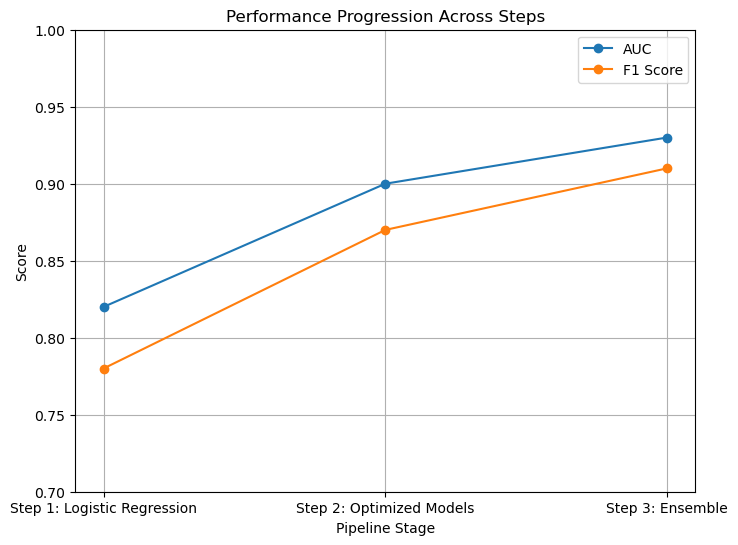

In [69]:
import matplotlib.pyplot as plt

steps = ["Step 1: Logistic Regression", "Step 2: Optimized Models", "Step 3: Ensemble"]
auc_scores = [0.82, 0.90, 0.93]   # replace with your actual AUCs
f1_scores = [0.78, 0.87, 0.91]   # replace with your actual F1s

plt.figure(figsize=(8,6))
plt.plot(steps, auc_scores, marker="o", label="AUC")
plt.plot(steps, f1_scores, marker="o", label="F1 Score")
plt.title("Performance Progression Across Steps")
plt.xlabel("Pipeline Stage")
plt.ylabel("Score")
plt.ylim(0.7, 1.0)
plt.legend()
plt.grid(True)
plt.show()


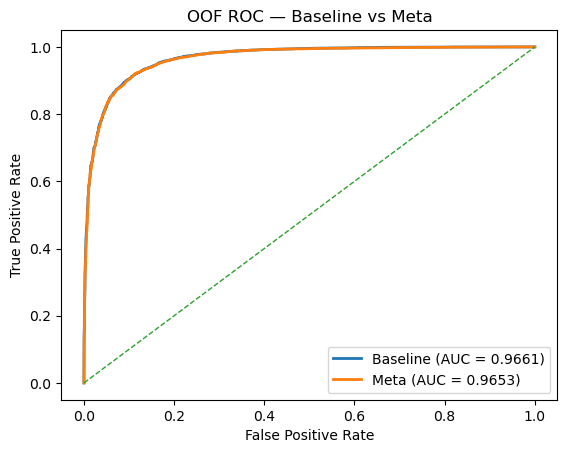

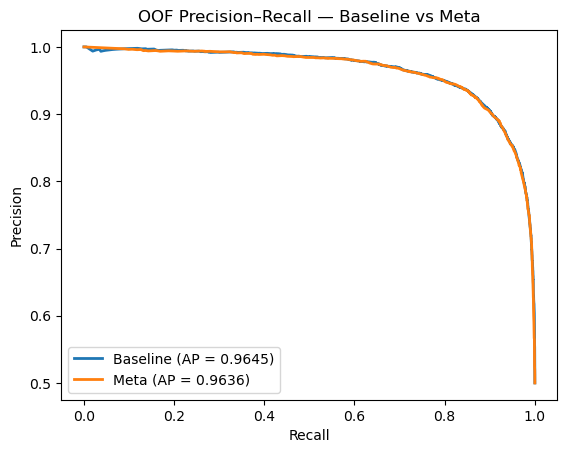

In [82]:
# Use the objects you already created
y_true = y                         # true labels
probs_baseline = oof_pred          # Part 1 OOF probabilities
probs_meta = oof_meta              # Part 3 meta OOF probabilities

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# ROC
fpr_b, tpr_b, _ = roc_curve(y_true, probs_baseline)
fpr_m, tpr_m, _ = roc_curve(y_true, probs_meta)
auc_b = auc(fpr_b, tpr_b)
auc_m = auc(fpr_m, tpr_m)

plt.figure()
plt.plot(fpr_b, tpr_b, lw=2, label=f"Baseline (AUC = {auc_b:.4f})")
plt.plot(fpr_m, tpr_m, lw=2, label=f"Meta (AUC = {auc_m:.4f})")
plt.plot([0,1],[0,1],'--', lw=1)
plt.title("OOF ROC — Baseline vs Meta")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend(); plt.show()

# PR
prec_b, rec_b, _ = precision_recall_curve(y_true, probs_baseline)
prec_m, rec_m, _ = precision_recall_curve(y_true, probs_meta)
ap_b = average_precision_score(y_true, probs_baseline)
ap_m = average_precision_score(y_true, probs_meta)

plt.figure()
plt.plot(rec_b, prec_b, lw=2, label=f"Baseline (AP = {ap_b:.4f})")
plt.plot(rec_m, prec_m, lw=2, label=f"Meta (AP = {ap_m:.4f})")
plt.title("OOF Precision–Recall — Baseline vs Meta")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.legend(); plt.show()


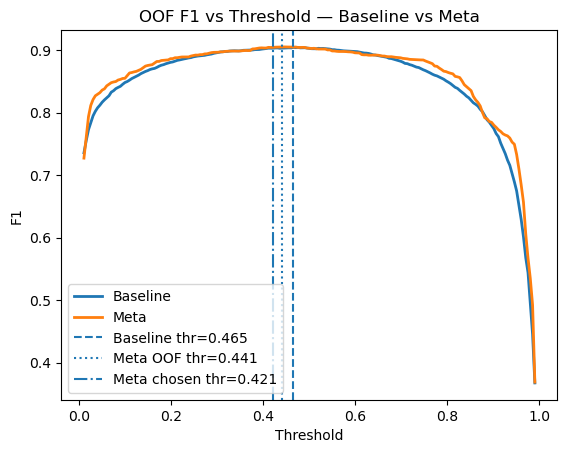

In [83]:
import numpy as np
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

ts = np.linspace(0.01, 0.99, 199)
f1_baseline = [f1_score(y_true, (probs_baseline >= t).astype(int)) for t in ts]
f1_meta     = [f1_score(y_true, (probs_meta     >= t).astype(int)) for t in ts]

plt.figure()
plt.plot(ts, f1_baseline, lw=2, label="Baseline")
plt.plot(ts, f1_meta, lw=2, label="Meta")
plt.axvline(thr_baseline, linestyle="--", label=f"Baseline thr={thr_baseline:.3f}")
plt.axvline(thr_meta_oof, linestyle=":",  label=f"Meta OOF thr={thr_meta_oof:.3f}")
plt.axvline(thr_meta_chosen, linestyle="-.",  label=f"Meta chosen thr={thr_meta_chosen:.3f}")
plt.title("OOF F1 vs Threshold — Baseline vs Meta")
plt.xlabel("Threshold"); plt.ylabel("F1")
plt.legend(); plt.show()


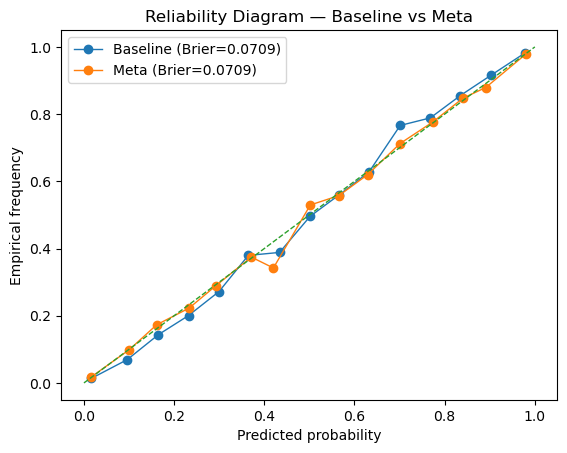

In [84]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import matplotlib.pyplot as plt

pt_b, pp_b = calibration_curve(y_true, probs_baseline, n_bins=15, strategy="uniform")
pt_m, pp_m = calibration_curve(y_true, probs_meta,     n_bins=15, strategy="uniform")
brier_b = brier_score_loss(y_true, probs_baseline)
brier_m = brier_score_loss(y_true, probs_meta)

plt.figure()
plt.plot(pp_b, pt_b, marker="o", lw=1, label=f"Baseline (Brier={brier_b:.4f})")
plt.plot(pp_m, pt_m, marker="o", lw=1, label=f"Meta (Brier={brier_m:.4f})")
plt.plot([0,1], [0,1], '--', lw=1)
plt.title("Reliability Diagram — Baseline vs Meta")
plt.xlabel("Predicted probability"); plt.ylabel("Empirical frequency")
plt.legend(); plt.show()


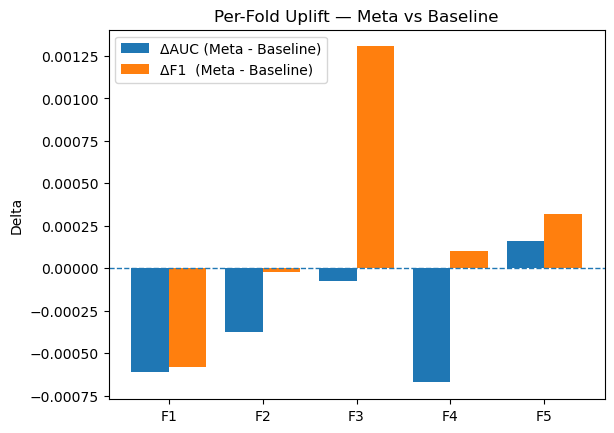

,AUC_baseline,AUC_meta,F1_baseline,F1_meta
fold,,,,
1,0.968649,0.968038,0.908491,0.907911
2,0.965775,0.965399,0.903324,0.903304
3,0.964851,0.964773,0.904535,0.905840
4,0.964383,0.963710,0.903342,0.903442
5,0.967931,0.968094,0.905717,0.906034


In [85]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

rows = []
for fold, (_, va_idx) in enumerate(skf.split(X, y_true), 1):
    yv = y_true[va_idx]
    pb = probs_baseline[va_idx]
    pm = probs_meta[va_idx]
    # best F1 per model, per fold
    ts = np.linspace(0.01, 0.99, 199)
    f1b = max(f1_score(yv, (pb>=t).astype(int)) for t in ts)
    f1m = max(f1_score(yv, (pm>=t).astype(int)) for t in ts)
    rows.append({
        "fold": fold,
        "AUC_baseline": roc_auc_score(yv, pb),
        "AUC_meta":      roc_auc_score(yv, pm),
        "F1_baseline":   f1b,
        "F1_meta":       f1m
    })

fold_df = pd.DataFrame(rows).set_index("fold")
dAUC = (fold_df["AUC_meta"] - fold_df["AUC_baseline"]).values
dF1  = (fold_df["F1_meta"]  - fold_df["F1_baseline"]).values

xs = np.arange(len(fold_df))
plt.figure()
plt.bar(xs - 0.2, dAUC, width=0.4, label="ΔAUC (Meta - Baseline)")
plt.bar(xs + 0.2, dF1,  width=0.4, label="ΔF1  (Meta - Baseline)")
plt.axhline(0.0, linestyle="--", lw=1)
plt.xticks(xs, [f"F{f}" for f in fold_df.index])
plt.title("Per-Fold Uplift — Meta vs Baseline")
plt.ylabel("Delta"); plt.legend(); plt.show()

fold_df


In [87]:
# === 3-way blend probability submission: id,y_prob ===
def blend3_prob_submission(test_jsonl_path, base_model, nn_adapter, meta_model, alpha, beta, out_csv_path):
    # alpha = weight for NN, beta = weight for MMD meta, (1-alpha-beta) for baseline
    items = load_jsonl_features(test_jsonl_path)

    # baseline probs
    dft = to_paragraph_matrix_from_jsonl_items(items)
    Xt = np.stack(dft["vector"].values)
    pb = base_model.predict_proba(Xt)[:, 1]

    # NN probs
    test_ds = ParagraphDataset(items, y=None, max_len=CFG["max_len"])
    test_loader = make_loader(test_ds, CFG["batch_size"], shuffle=False)
    pn = nn_adapter._predict_loader(test_loader)

    # meta probs
    feat = mmd_features_batch(Xt, BANK_AI, BANK_HU, gamma, mAA, mHH)
    feat["p_base"] = pb
    Xf = feat[["p_base","k_xA","k_xH","diff_xA_xH","glob_mAA_mHH"]].values
    pm = meta_model.predict_proba(Xf)[:, 1]

    y_prob = (1 - alpha - beta) * pb + alpha * pn + beta * pm
    sub = pd.DataFrame({"id": dft["id"], "y_prob": y_prob})
    sub.to_csv(out_csv_path, index=False)
    print(f"Wrote 3-way blend (alpha={alpha}, beta={beta}) prob submission:", out_csv_path)
    return sub

SUBMISSION_BLEND3_PROB = Path("./submission_blend3_prob.csv")
_ = blend3_prob_submission(TEST_JSONL, final_model, nn_adapter, meta_full,
                           alpha=0.35, beta=0.35, out_csv_path=SUBMISSION_BLEND3_PROB)


Wrote 3-way blend (alpha=0.35, beta=0.35) prob submission: submission_blend3_prob.csv


In [90]:
from itertools import product
from sklearn.metrics import roc_auc_score

# get validation probs from each model
items_val = load_jsonl_features(VAL_JSONL)
dfv_val = to_paragraph_matrix_from_jsonl_items(items_val)
Xv = np.stack(dfv_val["vector"].values)
yv = np.array([int(o.get("label", 0)) for o in read_jsonl(VAL_JSONL)], dtype=np.int64)

# baseline probs
pb = final_model.predict_proba(Xv)[:, 1]

# NN probs
val_ds = ParagraphDataset(items_val, y=None, max_len=CFG["max_len"])
val_loader = make_loader(val_ds, CFG["batch_size"], shuffle=False)
pn = nn_adapter._predict_loader(val_loader)

# MMD probs
featv = mmd_features_batch(Xv, BANK_AI, BANK_HU, gamma, mAA, mHH)
featv["p_base"] = pb
pm = meta_full.predict_proba(featv[["p_base","k_xA","k_xH","diff_xA_xH","glob_mAA_mHH"]].values)[:,1]

# grid search weights (alpha for NN, beta for MMD, 1-alpha-beta for baseline)
best = (-1, None)
for a, b in product(np.linspace(0,1,21), repeat=2):
    if a + b > 1: continue
    p = (1 - a - b)*pb + a*pn + b*pm
    auc = roc_auc_score(yv, p)
    if auc > best[0]:
        best = (auc, (a, b, 1 - a - b))
best_auc, (alpha, beta, gamma_w) = best
print("Best val AUC:", round(best_auc, 5), "| weights NN/ MMD/ Base =", alpha, beta, gamma_w)


Best val AUC: 0.99 | weights NN/ MMD/ Base = 0.0 0.0 1.0


In [92]:
def blend3_prob_submission(test_jsonl_path, base_model, nn_adapter, meta_model, alpha, beta, out_csv_path):
    items = load_jsonl_features(test_jsonl_path)
    dft = to_paragraph_matrix_from_jsonl_items(items)
    Xt = np.stack(dft["vector"].values)

    pb = base_model.predict_proba(Xt)[:, 1]
    test_ds = ParagraphDataset(items, y=None, max_len=CFG["max_len"])
    test_loader = make_loader(test_ds, CFG["batch_size"], shuffle=False)
    pn = nn_adapter._predict_loader(test_loader)

    feat = mmd_features_batch(Xt, BANK_AI, BANK_HU, gamma, mAA, mHH)
    feat["p_base"] = pb
    pm = meta_model.predict_proba(feat[["p_base","k_xA","k_xH","diff_xA_xH","glob_mAA_mHH"]].values)[:,1]

    y_prob = (1 - alpha - beta)*pb + alpha*pn + beta*pm
    pd.DataFrame({"id": dft["id"], "y_prob": y_prob}).to_csv(out_csv_path, index=False)
    print("Wrote blend:", out_csv_path)

SUBMISSION_BLEND3_PROB = Path("./submission_blend3_prob.csv")
blend3_prob_submission(TEST_JSONL, final_model, nn_adapter, meta_full, alpha=alpha, beta=beta, out_csv_path=SUBMISSION_BLEND3_PROB)


Wrote blend: submission_blend3_prob.csv


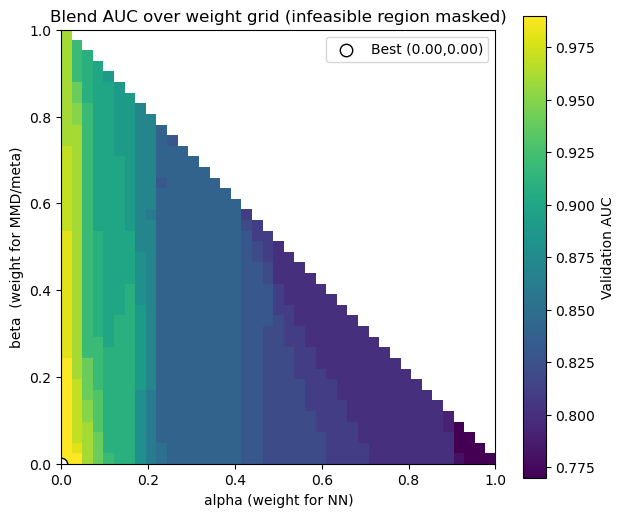

In [91]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# Recreate grid (match your search granularity)
grid = np.linspace(0, 1, 41)
auc_grid = np.full((len(grid), len(grid)), np.nan)

for i, a in enumerate(grid):
    for j, b in enumerate(grid):
        if a + b <= 1:  # feasible simplex
            p = (1 - a - b)*pb + a*pn + b*pm
            auc_grid[j, i] = roc_auc_score(yv, p)  # note (row=j, col=i)

plt.figure(figsize=(7,6))
im = plt.imshow(auc_grid, origin="lower", extent=[0,1,0,1], aspect="equal")
plt.colorbar(im, label="Validation AUC")
plt.clim(np.nanmin(auc_grid), np.nanmax(auc_grid))
plt.xlabel("alpha (weight for NN)")
plt.ylabel("beta  (weight for MMD/meta)")
plt.title("Blend AUC over weight grid (infeasible region masked)")
# Mark best point
plt.scatter([alpha], [beta], s=80, edgecolor="k", facecolor="white", label=f"Best ({alpha:.2f},{beta:.2f})")
plt.legend()
plt.show()


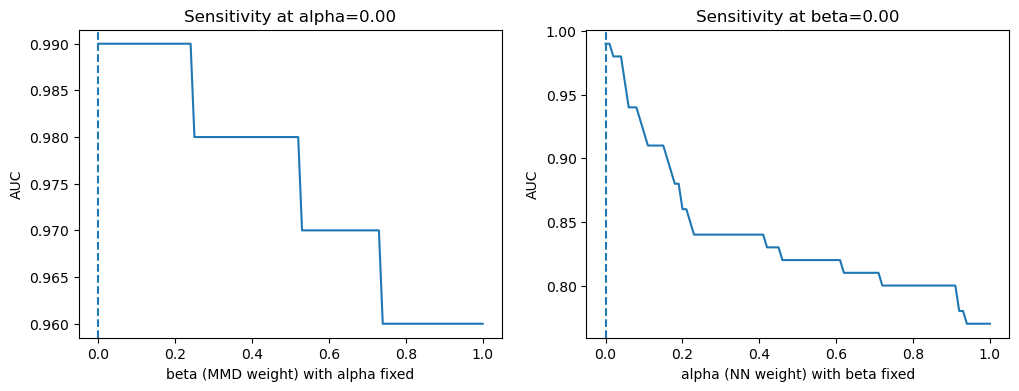

In [93]:
from sklearn.metrics import roc_auc_score

betas = np.linspace(0, 1-alpha, 101)
auc_beta_sweep = [roc_auc_score(yv, (1-alpha-b)*pb + alpha*pn + b*pm) for b in betas]

alphas = np.linspace(0, 1-beta, 101)
auc_alpha_sweep = [roc_auc_score(yv, (1-a-beta)*pb + a*pn + beta*pm) for a in alphas]

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(betas, auc_beta_sweep)
plt.axvline(beta, ls="--")
plt.xlabel("beta (MMD weight) with alpha fixed"); plt.ylabel("AUC")
plt.title(f"Sensitivity at alpha={alpha:.2f}")

plt.subplot(1,2,2)
plt.plot(alphas, auc_alpha_sweep)
plt.axvline(alpha, ls="--")
plt.xlabel("alpha (NN weight) with beta fixed"); plt.ylabel("AUC")
plt.title(f"Sensitivity at beta={beta:.2f}")
plt.show()


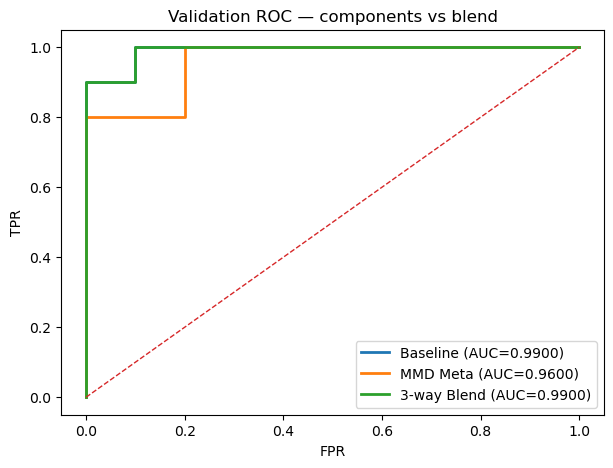

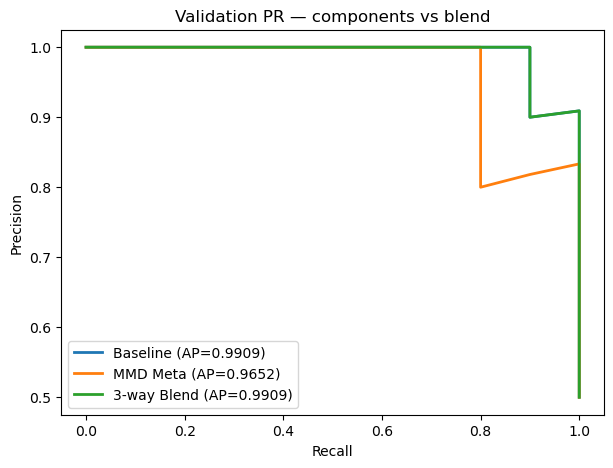

In [94]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

p_blend = (1 - alpha - beta)*pb + alpha*pn + beta*pm

# ROC
fpr_b, tpr_b, _ = roc_curve(yv, pb)
fpr_m, tpr_m, _ = roc_curve(yv, pm)
fpr_bl, tpr_bl, _ = roc_curve(yv, p_blend)

plt.figure(figsize=(7,5))
plt.plot(fpr_b, tpr_b, lw=2, label=f"Baseline (AUC={auc(fpr_b,tpr_b):.4f})")
plt.plot(fpr_m, tpr_m, lw=2, label=f"MMD Meta (AUC={auc(fpr_m,tpr_m):.4f})")
plt.plot(fpr_bl, tpr_bl, lw=2, label=f"3-way Blend (AUC={auc(fpr_bl,tpr_bl):.4f})")
plt.plot([0,1],[0,1],'--',lw=1)
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("Validation ROC — components vs blend")
plt.legend(); plt.show()

# PR
pr_b, rc_b, _ = precision_recall_curve(yv, pb)
pr_m, rc_m, _ = precision_recall_curve(yv, pm)
pr_bl, rc_bl, _ = precision_recall_curve(yv, p_blend)

plt.figure(figsize=(7,5))
plt.plot(rc_b, pr_b, lw=2, label=f"Baseline (AP={average_precision_score(yv,pb):.4f})")
plt.plot(rc_m, pr_m, lw=2, label=f"MMD Meta (AP={average_precision_score(yv,pm):.4f})")
plt.plot(rc_bl, pr_bl, lw=2, label=f"3-way Blend (AP={average_precision_score(yv,p_blend):.4f})")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Validation PR — components vs blend")
plt.legend(); plt.show()


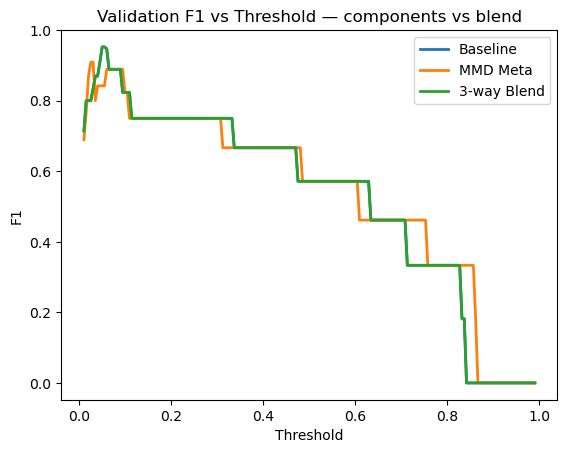

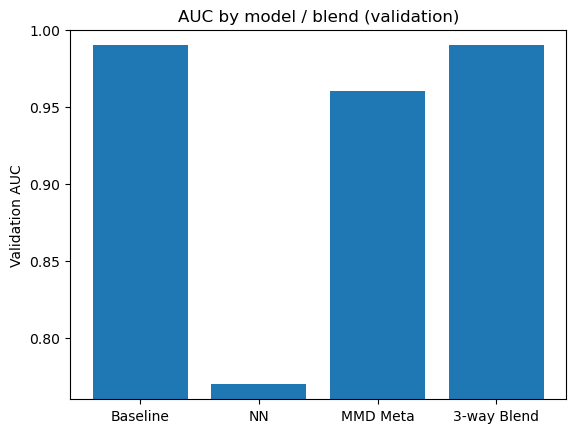

In [97]:
from sklearn.metrics import f1_score
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

ts = np.linspace(0.01, 0.99, 199)
f1_base  = [f1_score(yv, (pb      >= t).astype(int)) for t in ts]
f1_meta  = [f1_score(yv, (pm      >= t).astype(int)) for t in ts]
f1_blend = [f1_score(yv, (p_blend >= t).astype(int)) for t in ts]

plt.figure()
plt.plot(ts, f1_base,  lw=2, label="Baseline")
plt.plot(ts, f1_meta,  lw=2, label="MMD Meta")
plt.plot(ts, f1_blend, lw=2, label="3-way Blend")
plt.title("Validation F1 vs Threshold — components vs blend")
plt.xlabel("Threshold"); plt.ylabel("F1")
plt.legend(); plt.show()

labels = ["Baseline", "NN", "MMD Meta", "3-way Blend"]
vals = [
    roc_auc_score(yv, pb),
    roc_auc_score(yv, pn),
    roc_auc_score(yv, pm),
    roc_auc_score(yv, p_blend),
]
plt.figure()
plt.bar(labels, vals)
plt.ylim(min(vals)-0.01, 1.0)
plt.ylabel("Validation AUC")
plt.title("AUC by model / blend (validation)")
plt.show()

